# Prédiction de défaut des prêts SBA

---
# Résumé du Projet

Ce projet, construit sur les prêts historiques du programme **7(a) de la SBA** (US Small Business Administration), vise à prédire le risque de défaut (`LoanStatus`) d'une entreprise participant à ce programme. Ainsi l'objectif du modèle est de distinguer efficacement les prêts remboursés (*Paid in Full*) des pertes sèches (*Charged Off*).

Le projet est construit en plusieurs étapes :

1.  **Analyse Temporelle :** Au début du projet, les données disponibles depuis le début des années 2000 ont été analysées afin de comprendre les relations entre les différentes variables disponibles ainsi que l'évolution dans le temps des défauts. L'analyse a montré la **nécessité** de réduire la période d'étude suite aux variations des cycles macroéconomiques observées dans le temps. Ainsi, la période d'étude a été réduite à **2021-2024** afin de capter les dernières tendances économiques et éviter d'apprendre sur des données qui ne sont aujourd'hui plus d'actualité.

2.  **Enrichissement Macroéconomique :** En plus des variables disponibles dans les tables fournies par la SBA, nous avons ajouté des **variables macroéconomiques** au modèle afin de lui donner des indications sur les périodes de crise et de changement macroéconomique. Afin d'éviter tout *data leakage* possible, mais aussi dans le but de construire un projet réaliste et non seulement prédictif, ces variables macroéconomiques ont été utilisées avec un **décalage temporel** (ex : croissance du PIB de l'année précédente et non de l'année actuelle).

3.  **Validation "Business" :** Afin de capter la pertinence de ce modèle, des règles utilisées directement en entreprise ont été appliquées. Ainsi, le découpage en échantillon *train/test* respecte la temporalité et le modèle final est validé sur un échantillon **Out-of-Time (OOT)** afin de tester la stabilité des performances dans le temps.

4.  **Modélisation Hybride :** Plusieurs modèles seront comparés, en commençant par une **régression logistique** en tant que modèle benchmark, puis des modèles plus avancés (**Boosting, Bagging**) seront également testés. Différentes méthodes de sélection de variables (**Lasso, Elastic Net**) sont évaluées ainsi que différentes méthodes d'encodage des variables catégorielles (**WoE binning, One-Hot encoding**).

# Le Dataset (SBA 7(a) & 504)
Les données de départ (disponibles directement sur https://data.sba.gov/dataset/) contiennent plusieurs variables de différentes nature sur :
* **L'Emprunteur :** Localisation (`ProjectState`), Secteur d'activité (`NAICS`, `Industry`), Ancienneté.
* **La Structure du Prêt :** Montant (`GrossApproval`), Partie Garantie (`SBAGuaranteedApproval`), Durée (`TermInMonths`), Type (`RevolverStatus`).
* **Le Prêteur :** Qualité de la banque (`BankName`) et méthode d'octroi (`ProcessingMethod`).
* **Impact & Collatéral :** Emplois soutenus (`JobsSupported`) et présence de garanties (`CollateralInd`).
---

# Importation des librairies

In [113]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from optbinning import OptimalBinning



from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



from catboost import CatBoostClassifier, Pool, metrics


from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

# 1. Récupération des données et premiers filtrage

In [2]:
# 2000 - 2009
df1 = pd.read_csv('data/foia-7a-fy2000-fy2009-asof-250930.csv')

# 2010 - 2019
df2 = pd.read_csv('data/foia-7a-fy2010-fy2019-asof-250930.csv')

# 2020 - present
df3 = pd.read_csv('data/foia-7a-fy2020-present-asof-250930.csv')

df = pd.concat([df1, df2,  df3])


/var/folders/1j/c4tp9nxx665dfg322ydf_mfw0000gn/T/ipykernel_23157/1429824711.py:2: DtypeWarning: Columns (14,23,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('data/foia-7a-fy2000-fy2009-asof-250930.csv')
/var/folders/1j/c4tp9nxx665dfg322ydf_mfw0000gn/T/ipykernel_23157/1429824711.py:5: DtypeWarning: Columns (14,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/foia-7a-fy2010-fy2019-asof-250930.csv')
/var/folders/1j/c4tp9nxx665dfg322ydf_mfw0000gn/T/ipykernel_23157/1429824711.py:8: DtypeWarning: Columns (36,37,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('data/foia-7a-fy2020-present-asof-250930.csv')


In [3]:
df.shape

(1583598, 43)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1583598 entries, 0 to 347513
Data columns (total 43 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   AsOfDate                     1583598 non-null  object 
 1   Program                      1583598 non-null  object 
 2   BorrName                     1583563 non-null  object 
 3   BorrStreet                   1583579 non-null  object 
 4   BorrCity                     1583598 non-null  object 
 5   BorrState                    1583598 non-null  object 
 6   BorrZip                      1583598 non-null  int64  
 7   LocationID                   1582421 non-null  float64
 8   BankName                     1583598 non-null  object 
 9   BankFDICNumber               1437677 non-null  float64
 10  BankNCUANumber               39120 non-null    float64
 11  BankStreet                   1582420 non-null  object 
 12  BankCity                     1582421 non-null  o

In [5]:
# GrossApproval correspond au montant total du prêt
# SBAGuaranteedApproval correspond au montant garantit SBA
pd.options.display.max_columns = None
df.head(3)

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,LocationID,BankName,BankFDICNumber,BankNCUANumber,BankStreet,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFY,FirstDisbursementDate,ProcessingMethod,Subprogram,InitialInterestRate,FixedorVariableInterestRate,TerminMonths,NAICSCode,NAICSDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,BusinessAge,LoanStatus,PaidinFullDate,ChargeoffDate,GrossChargeoffAmount,RevolverStatus,JobsSupported,CollateralInd,SoldSecondMarketInd
0,2025-09-30,7A,AUTOHAUS STUTTGART,7961 BALBOA AVENUE,SAN DIEGO,CA,92111,199911.0,"Wachovia SBA Lending, Inc.",NaN,NaN,1620 E. Roseville Pkwy,ROSEVILLE,CA,95661,914000.0,685500.0,10/01/1999,2000,NaN,Preferred Lenders Program,Guaranty,NaN,NaN,300,811111.0,General Automotive Repair,NaN,NaN,SAN DIEGO,CA,SAN DIEGO DISTRICT OFFICE,52.0,INDIVIDUAL,NaN,CANCLD,NaN,NaN,0.00,0,10.0,NaN,NaN
1,2025-09-30,7A,COTTMAN TRANSMISSION,4210 RED BLUFF RD,PASADENA,TX,77503,262382.0,Loans from Old Closed Lenders,NaN,NaN,409 3rd Street S.W.,Washington,DC,20416,460400.0,345300.0,10/01/1999,2000,10/31/1999,Preferred Lenders Program,Guaranty,NaN,NaN,217,811113.0,Automotive Transmission Repair,20550,COTTMAN TRANSMISSION,HARRIS,TX,HOUSTON DISTRICT OFFICE,29.0,CORPORATION,NaN,CHGOFF,NaN,06/05/2001,123184.59,0,12.0,Y,Y
2,2025-09-30,7A,GOSSELIN & SON TRUCKING INC,660 OLD FALL RIVER RD,NORTH DARTMOUTH,MA,2747,9551.0,"Bank of America, National Association",3510.0,NaN,100 North Tryon Street,Charlotte,NC,28255,36000.0,18000.0,10/01/1999,2000,10/31/1999,SBA Express Program,FA$TRK (Small Loan Express),NaN,NaN,36,NaN,NaN,NaN,NaN,BRISTOL,MA,MASSACHUSETTS DISTRICT OFFICE,9.0,CORPORATION,NaN,PIF,05/31/2005,NaN,0.00,0,2.0,NaN,NaN


In [6]:
df.isna().sum()/df.shape[0]

AsOfDate                       0.000000
Program                        0.000000
BorrName                       0.000022
BorrStreet                     0.000012
BorrCity                       0.000000
BorrState                      0.000000
BorrZip                        0.000000
LocationID                     0.000743
BankName                       0.000000
BankFDICNumber                 0.092145
BankNCUANumber                 0.975297
BankStreet                     0.000744
BankCity                       0.000743
BankState                      0.000746
BankZip                        0.000743
GrossApproval                  0.000000
SBAGuaranteedApproval          0.000000
ApprovalDate                   0.000000
ApprovalFY                     0.000000
FirstDisbursementDate          0.136391
ProcessingMethod               0.000000
Subprogram                     0.000000
InitialInterestRate            0.412798
FixedorVariableInterestRate    0.412797
TerminMonths                   0.000000


In [7]:
for col in df.columns:
    if (df[col].isna().sum()/df.shape[0]) > 0.3:
        df = df.drop(col, axis= 1)
    else:
        pass

In [8]:
df.isna().sum()/df.shape[0]

AsOfDate                 0.000000
Program                  0.000000
BorrName                 0.000022
BorrStreet               0.000012
BorrCity                 0.000000
BorrState                0.000000
BorrZip                  0.000000
LocationID               0.000743
BankName                 0.000000
BankFDICNumber           0.092145
BankStreet               0.000744
BankCity                 0.000743
BankState                0.000746
BankZip                  0.000743
GrossApproval            0.000000
SBAGuaranteedApproval    0.000000
ApprovalDate             0.000000
ApprovalFY               0.000000
FirstDisbursementDate    0.136391
ProcessingMethod         0.000000
Subprogram               0.000000
TerminMonths             0.000000
NAICSCode                0.012490
NAICSDescription         0.029182
ProjectCounty            0.000000
ProjectState             0.000000
SBADistrictOffice        0.000000
CongressionalDistrict    0.001516
BusinessType             0.000000
LoanStatus    

In [9]:
df.loc[df["GrossChargeoffAmount"]>0]["LoanStatus"].value_counts()

LoanStatus
CHGOFF    182040
Name: count, dtype: int64

In [10]:
# target 
df['LoanStatus'].value_counts()

LoanStatus
PIF       896899
EXEMPT    290517
CANCLD    188919
CHGOFF    182061
COMMIT     25199
Name: count, dtype: int64

les modalités de la variable cible:
- **PIF** = PAID in full (donc remboursement total de l'entreprise et pas de défaut)
- **CHGOFF** = CHARGED OFF (donc l'emprunteur a arrêter de payer ==> Défaut)

ON a également:
- **COMMIT** = COMMITMENT / UNDISBURSED (à supprimer car le prêt n'a pas encore été donné)
- **CANCLD** = Cancelled (le contrat est annulé et le prêt n'a pas été approuvé donc à supprimer aussi de la base)

In [11]:
df = df.loc[(df["LoanStatus"] == 'PIF') | (df['LoanStatus'] == 'CHGOFF')]

In [12]:
df["LoanStatus"].value_counts(normalize=True)

LoanStatus
PIF       0.831263
CHGOFF    0.168737
Name: proportion, dtype: float64

In [13]:
# Pour ne pas faire de data leakage et colonnes inutiles pour le moment
df = df.drop(columns={"GrossChargeoffAmount",
                               "AsOfDate"})

In [14]:
# On binarise la cible
df["LoanStatus"] = np.where(df["LoanStatus"] == 'PIF', 0, 1)

# 2. DATA ANALYSE

In [15]:
pd.options.display.max_columns = None
df.head()

,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,LocationID,BankName,BankFDICNumber,BankStreet,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFY,FirstDisbursementDate,ProcessingMethod,Subprogram,TerminMonths,NAICSCode,NAICSDescription,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,RevolverStatus,JobsSupported,CollateralInd
1,7A,COTTMAN TRANSMISSION,4210 RED BLUFF RD,PASADENA,TX,77503,262382.0,Loans from Old Closed Lenders,NaN,409 3rd Street S.W.,Washington,DC,20416,460400.0,345300.0,10/01/1999,2000,10/31/1999,Preferred Lenders Program,Guaranty,217,811113.0,Automotive Transmission Repair,HARRIS,TX,HOUSTON DISTRICT OFFICE,29.0,CORPORATION,1,0,12.0,Y
2,7A,GOSSELIN & SON TRUCKING INC,660 OLD FALL RIVER RD,NORTH DARTMOUTH,MA,2747,9551.0,"Bank of America, National Association",3510.0,100 North Tryon Street,Charlotte,NC,28255,36000.0,18000.0,10/01/1999,2000,10/31/1999,SBA Express Program,FA$TRK (Small Loan Express),36,NaN,NaN,BRISTOL,MA,MASSACHUSETTS DISTRICT OFFICE,9.0,CORPORATION,0,0,2.0,NaN
3,7A,Vande Hey Company Inc.,N2093 COUNTY ROAD N,APPLETON,WI,54915,75939.0,"Associated Bank, National Association",5296.0,200 N Adams St,GREEN BAY,WI,54301,100000.0,80000.0,10/01/1999,2000,11/30/1999,7a General,Guaranty,120,NaN,NaN,OUTAGAMIE,WI,WISCONSIN DISTRICT OFFICE,6.0,CORPORATION,0,0,0.0,N
4,7A,NORTHSTAR ANIMAL CLINIC PC,2004 BLACKBURN RD.,SACHSE,TX,75048,71616.0,LegacyTexas Bank,18843.0,PO Box 869111,Plano,TX,75024,151000.0,113250.0,10/01/1999,2000,12/31/1999,Preferred Lenders Program,Guaranty,84,235410.0,Masonry and Stone Contractors,DALLAS,TX,DALLAS / FT WORTH DISTRICT OFFICE,3.0,CORPORATION,0,0,3.0,NaN
5,7A,HOLLY INN PARTNERSHIP,153 AMPEY RD.,PAW PAW,MI,49079,58036.0,Fifth Third Bank,6672.0,38 Fountain Sq Plz,CINCINNATI,OH,45263,653000.0,489750.0,10/01/1999,2000,10/31/2000,Preferred Lenders Program,Guaranty,180,551112.0,Offices of Other Holding Companies,VAN BUREN,MI,MICHIGAN DISTRICT OFFICE,6.0,PARTNERSHIP,0,0,23.0,NaN


In [16]:
# On garde seulement la dernière date d'obs d'un meme pret
df = df.drop_duplicates(subset=["BorrName", "BorrStreet", "BorrCity", "FirstDisbursementDate"], keep="last")
df = df.drop_duplicates()

In [17]:
df["ApprovalDate"]= pd.to_datetime(df["ApprovalDate"], errors='coerce')
# Mise au format date
df["FirstDisbursementDate"] = pd.to_datetime(df["FirstDisbursementDate"])
df = df.set_index("ApprovalDate")

In [18]:
df = df.drop(columns={'Program',
                      'BorrName',
                      'BorrStreet',
                      'BorrCity',
                      'LocationID',
                      'BankFDICNumber',
                      'BankZip',
                      'BankStreet',
                      'BankCity',
                      'NAICSDescription',
                      'CongressionalDistrict',
                      "BorrZip"
})

In [19]:
print(df.shape)
df.columns

(1059495, 19)


Index(['BorrState', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd'],
      dtype='object')

## 2.1. Valeurs manquantes

### A - Variables numériques 

In [20]:
# Pas de valeurs manquantes pour les variables numériques
col_numericals = ["GrossApproval", "SBAGuaranteedApproval", "TerminMonths", "JobsSupported"]
df[col_numericals].isna().sum()

GrossApproval            0
SBAGuaranteedApproval    0
TerminMonths             0
JobsSupported            0
dtype: int64

### B - Variables catégorielles 

In [21]:
col_restants = [col for col in df.columns if col not in col_numericals]
df[col_restants].isna().sum()

BorrState                    0
BankName                     0
BankState                  667
ApprovalFY                   0
FirstDisbursementDate     1868
ProcessingMethod             0
Subprogram                   0
NAICSCode                16749
ProjectCounty                0
ProjectState                 0
SBADistrictOffice            0
BusinessType                 0
LoanStatus                   0
RevolverStatus               0
CollateralInd            85031
dtype: int64

In [22]:
# On voit que lorsque Bankstate est manquant on a MISSINGMAINBANKID comme nom de banque (inconnu)
df.loc[df["BankState"].isna()]

# On va donc imputer ces valeurs dans une catégorie "unknown"
df["BankName"] = np.where(df["BankName"]=="MISSINGMAINBANKID", "unknown", df["BankName"])
df["BankState"] = np.where(df["BankState"].isna(), "unknown", df["BankState"])
print(f'Nombre de lignes imputées {df[df["BankState"] == "unknown"].shape[0]}')

Nombre de lignes imputées 667


In [23]:
# Les lignes ou FirstDisbursementDate est manquant les autres variables sont renseignées
df.loc[df['FirstDisbursementDate'].isna()]
# Sachant que le premier versement arrive après un certain temps de la date d'approbation on peut prendre la médiane (dans tout les cas ca n'aura pas un grand impact car peu de valeurs manquantes)
approval_dates = df.index.to_series()
delai_median = (df['FirstDisbursementDate'] - approval_dates).median()
valeurs_remplacement = approval_dates + delai_median
df['FirstDisbursementDate'] = df['FirstDisbursementDate'].fillna(valeurs_remplacement)

In [24]:
# Pour la variable CollateralInd on a deux possibilités (oui/non), pour povuoir garder la variable on fait l'hypothèse que NaN = No
df["CollateralInd"]=df["CollateralInd"].fillna(0)
df["CollateralInd"] = np.where(df['CollateralInd'] == "Y", 1, 0)
df.CollateralInd.value_counts()

CollateralInd
0    638905
1    420590
Name: count, dtype: int64

In [25]:
# Seule possibilité est d'imputer par 'inconnu' pour NAICSCode
df["NAICSCode"] = df["NAICSCode"].fillna("inconnu")

# 3. DATA VIZUALISATION

## 3.1 Analayse de la variable cible dans le temps

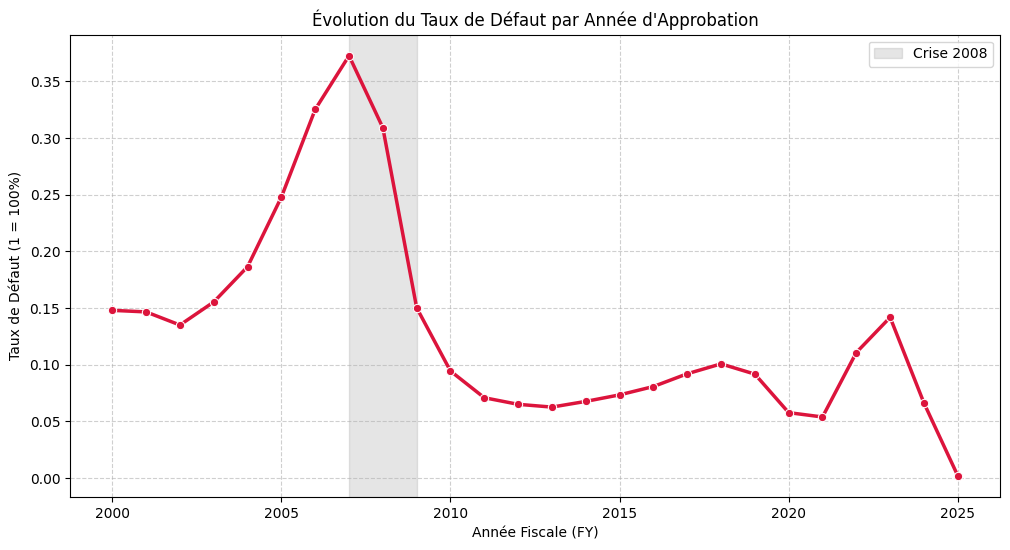

In [26]:
defaut_par_an = df.groupby('ApprovalFY')['LoanStatus'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=defaut_par_an, marker='o', color='crimson', linewidth=2.5)

plt.title("Évolution du Taux de Défaut par Année d'Approbation")
plt.ylabel("Taux de Défaut (1 = 100%)")
plt.xlabel("Année Fiscale (FY)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvspan(2007, 2009, color='gray', alpha=0.2, label='Crise 2008')
plt.legend()
plt.show()

- On voit graphiquement que de manière logique on a un pic des faillites en sur la période de la crise de 2008
- Il semble également y avoir un pic retardé de l'effet de la crise covid
- A voir si on garde la période de 2008 sachant que ca peut ajouter du bruit inutile dans le modèle (peutetre mettre une indicatrice des périodes de crise)
- On a une chute assez importante sur la dernière période (pas assez de données ?)

## 3.2 Visualisation des variables numériques 

In [27]:
df_num = df[col_numericals]

In [28]:
df_num.describe().round(3)

,GrossApproval,SBAGuaranteedApproval,TerminMonths,JobsSupported
count,1059495.000,1059495.000,1059495.000,1059495.000
mean,255927.729,187750.704,103.539,9.033
std,504655.518,389086.347,72.156,24.773
min,55.000,46.750,0.000,0.000
25%,25300.000,15000.000,60.000,1.000
50%,80000.000,50000.000,84.000,4.000
75%,250000.000,175000.000,120.000,10.000
max,5000000.000,4500000.000,569.000,9500.000


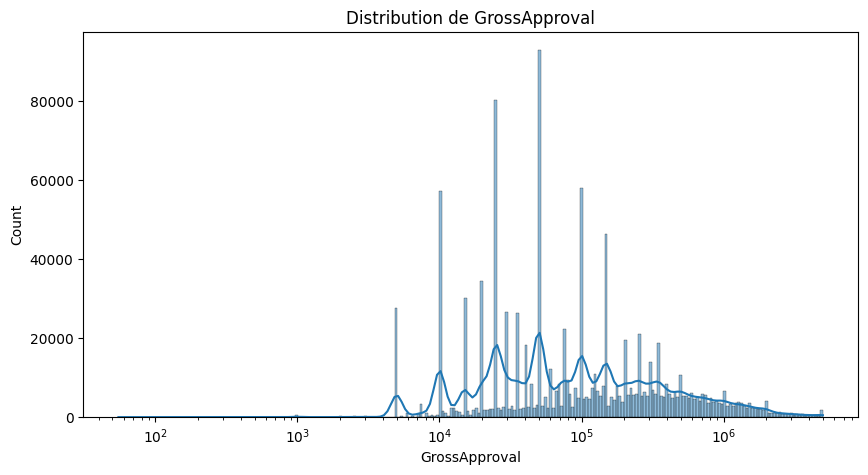

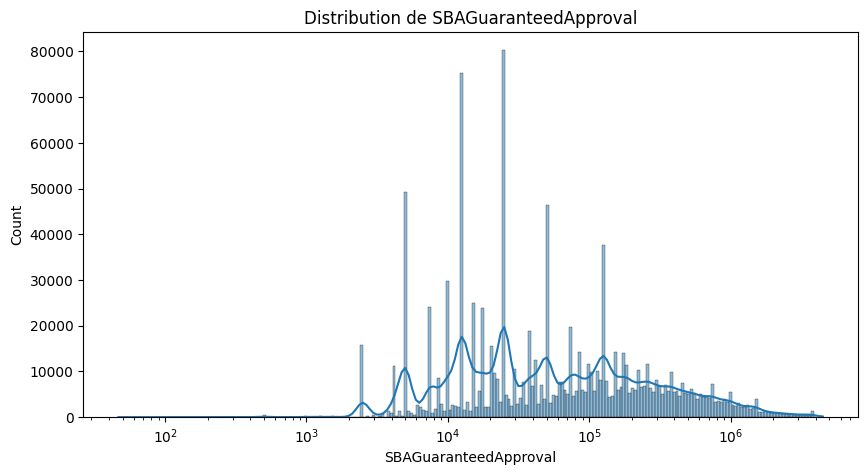

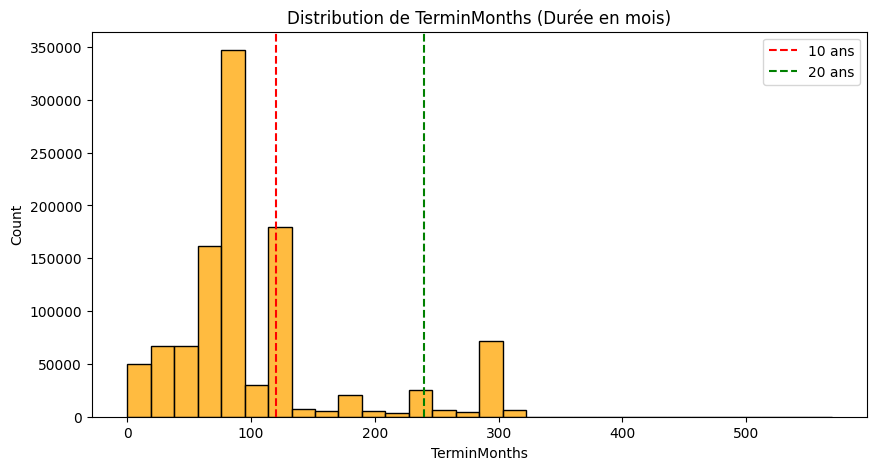

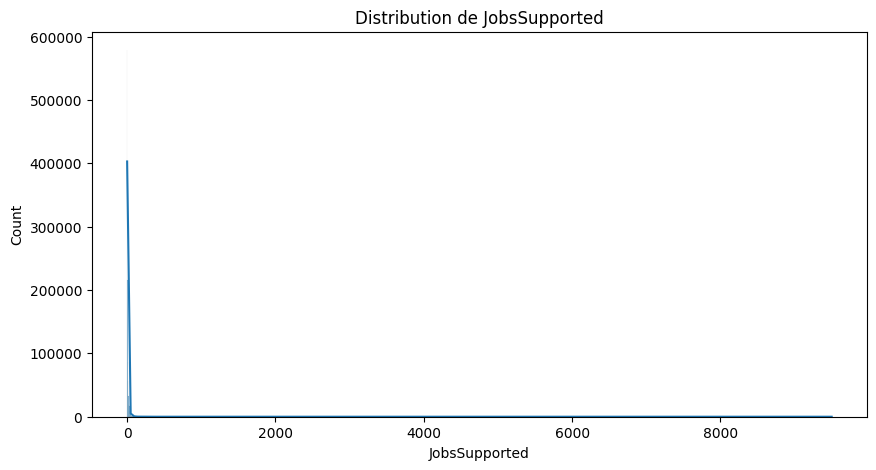

In [29]:
#Visualisation graphique
for col in df_num.columns:
    plt.figure(figsize=(10, 5))

    if "Approval" in col:
        sns.histplot(data=df, x=col, kde=True, log_scale=True)
        plt.title(f"Distribution de {col}")
        
    elif "Termin" in col:
        sns.histplot(data=df, x=col, kde=False, bins=30, color='orange')
        plt.title(f"Distribution de {col} (Durée en mois)")
        plt.axvline(x=120, color='r', linestyle='--', label='10 ans') # 120 mois
        plt.axvline(x=240, color='g', linestyle='--', label='20 ans') # 240 mois
        plt.legend()
    else:
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f"Distribution de {col}")

    plt.show()

- On voit qu'on a surtout à faire à des petites entreprises au vu de la distribution des emploi crées
- Les montants prêtés et garantis ont des distributions assez proches
- On a surtout à faire à des prêts de moins de 10 ans 

## 3.2.1 Visualisation des variables en fonction de la cible

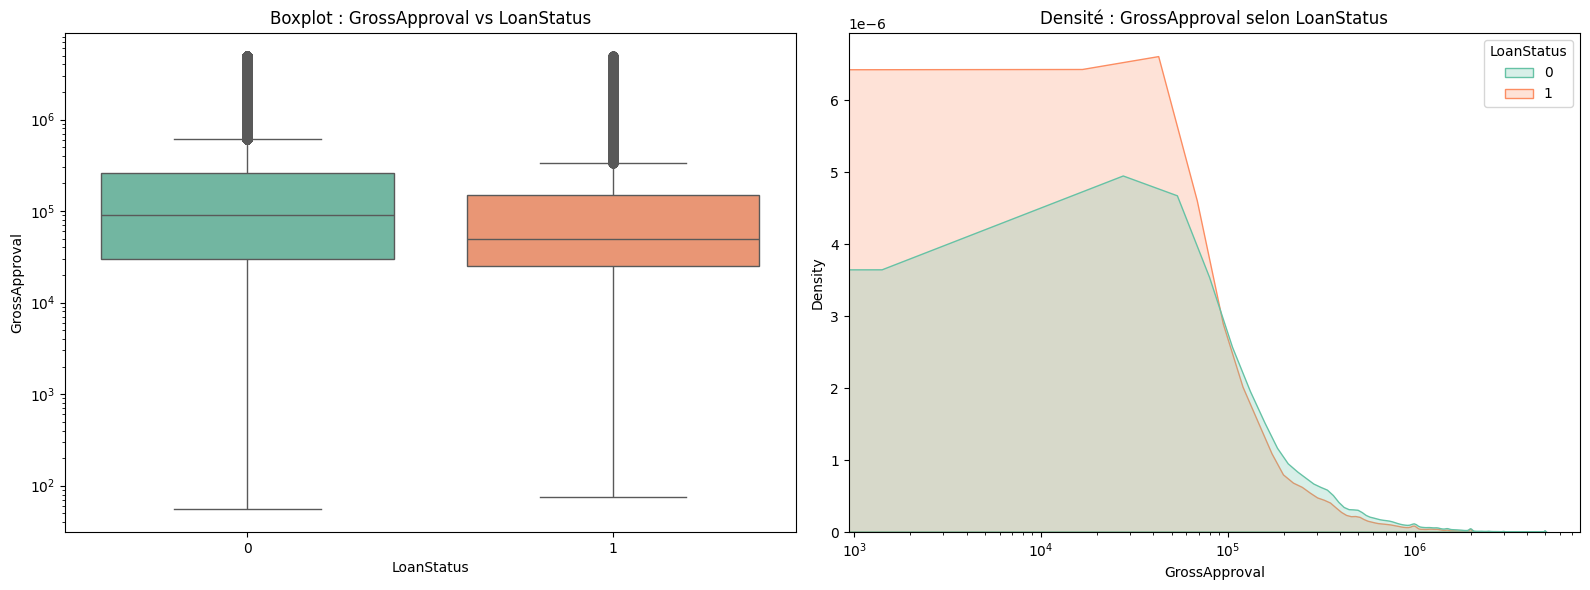

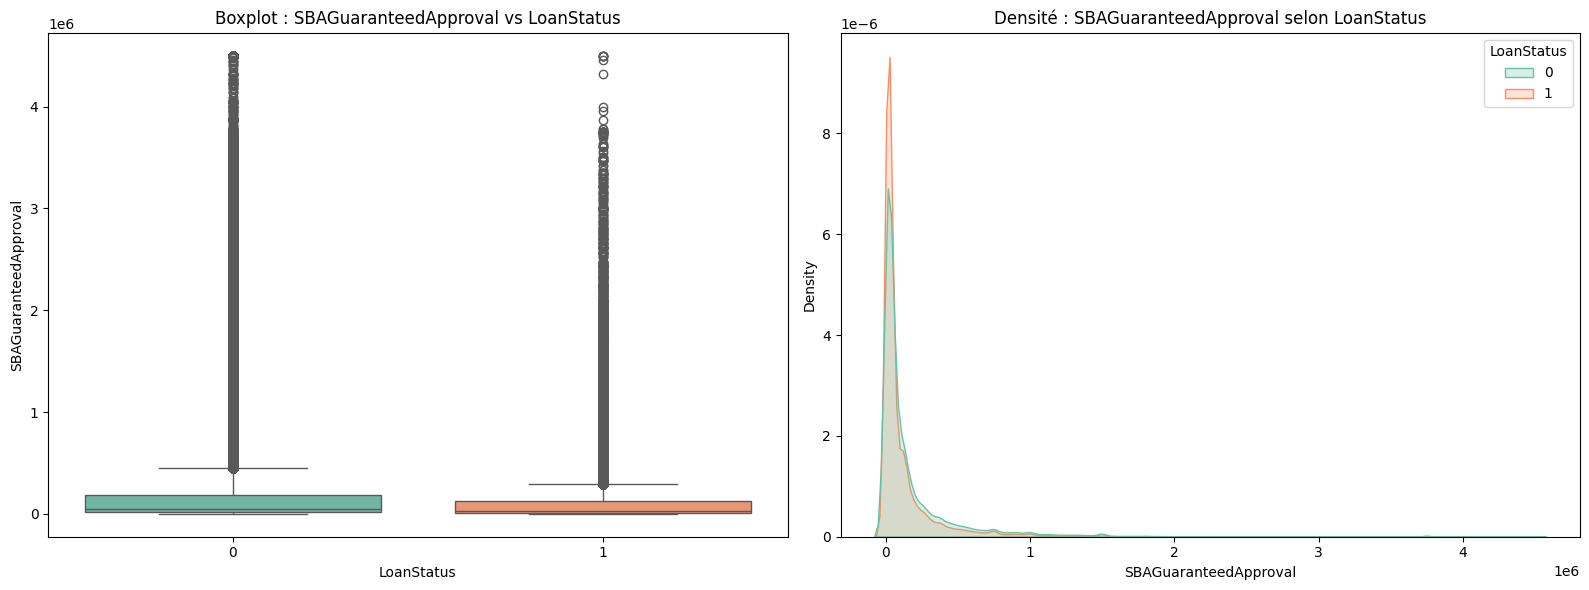

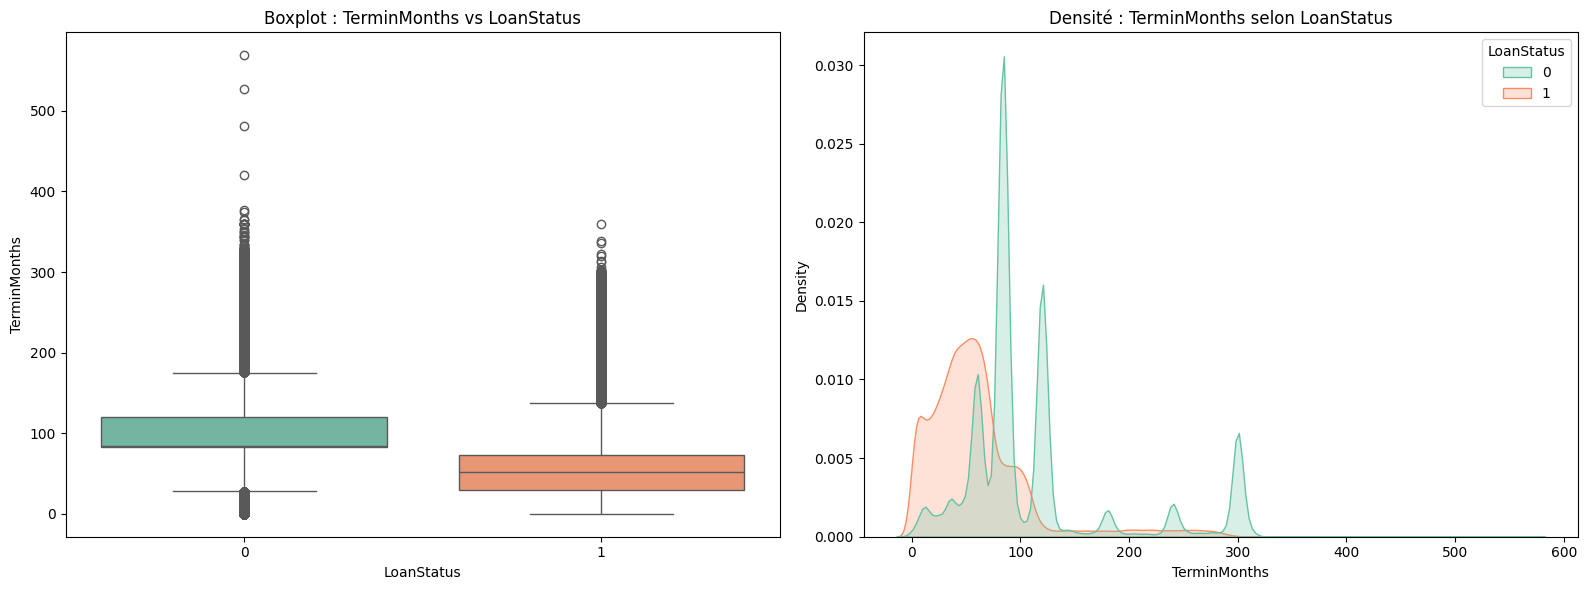

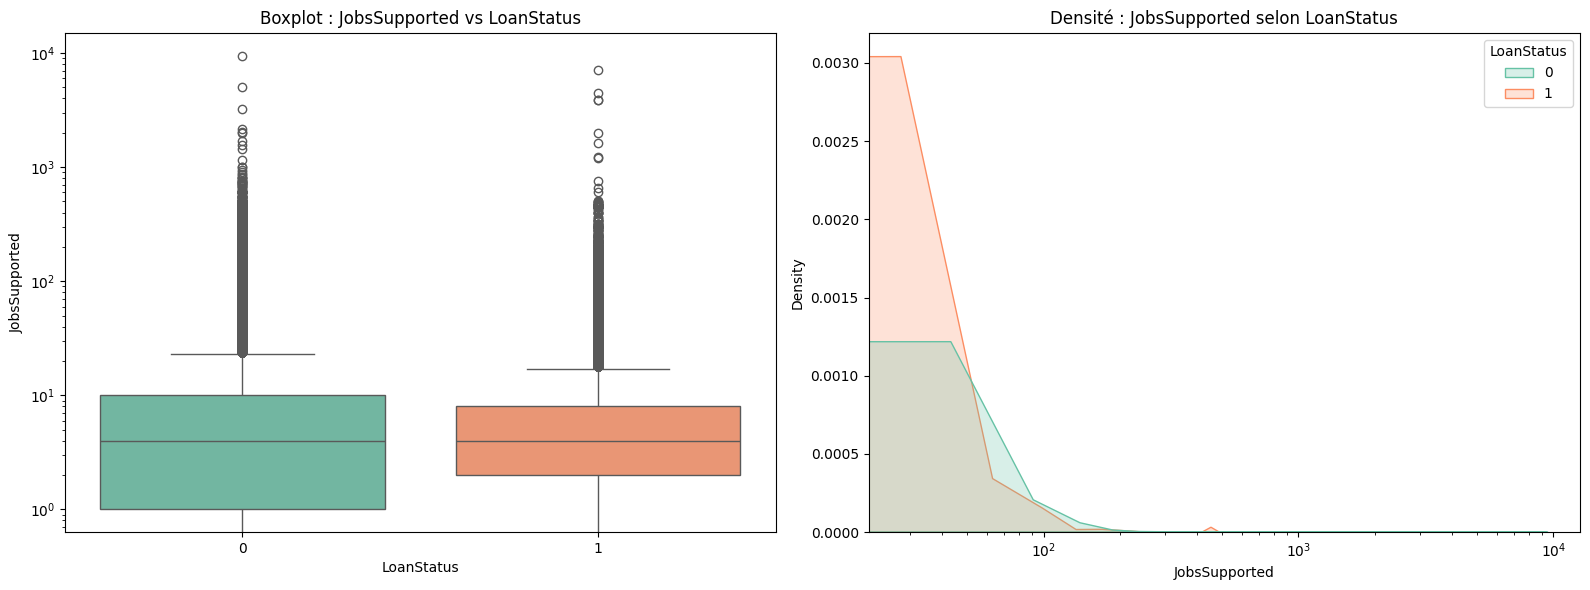

In [30]:
for col in df_num.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(
        data=df, 
        x='LoanStatus', 
        y=col, 
        hue='LoanStatus',  
        legend=False,    
        ax=axes[0], 
        palette="Set2"
    )
    axes[0].set_title(f"Boxplot : {col} vs LoanStatus")
    

    if col in ['GrossApproval', 'JobsSupported']:
        axes[0].set_yscale('log')
    
    sns.kdeplot(
        data=df, 
        x=col, 
        hue='LoanStatus', 
        fill=True, 
        common_norm=False, 
        ax=axes[1], 
        palette="Set2"
    )
    axes[1].set_title(f"Densité : {col} selon LoanStatus")
    
    if col in ['GrossApproval', 'JobsSupported']:
        axes[1].set_xscale('log')

    plt.tight_layout()
    plt.show()

## 3.3 Visualisation des variables catégorielles 

In [31]:
df["BusinessType"] = np.where(df["BusinessType"]== " ", "unknown", df["BusinessType"])
df.BusinessType.value_counts()
# On supprime les lignes ou on n'a pas de business type

BusinessType
CORPORATION    838006
INDIVIDUAL     196159
PARTNERSHIP     24872
                  458
Name: count, dtype: int64

In [32]:
df = df.loc[df["BusinessType"].isin(["CORPORATION", "INDIVIDUAL", "PARTNERSHIP"])]
df.BusinessType.value_counts()

BusinessType
CORPORATION    838006
INDIVIDUAL     196159
PARTNERSHIP     24872
Name: count, dtype: int64

*Pour la variable NAICS code on peut trouver le secteur d'activité de l'entreprise à partir des deux premiers chiffres (permettra de différencier le risque selon le secteur)*

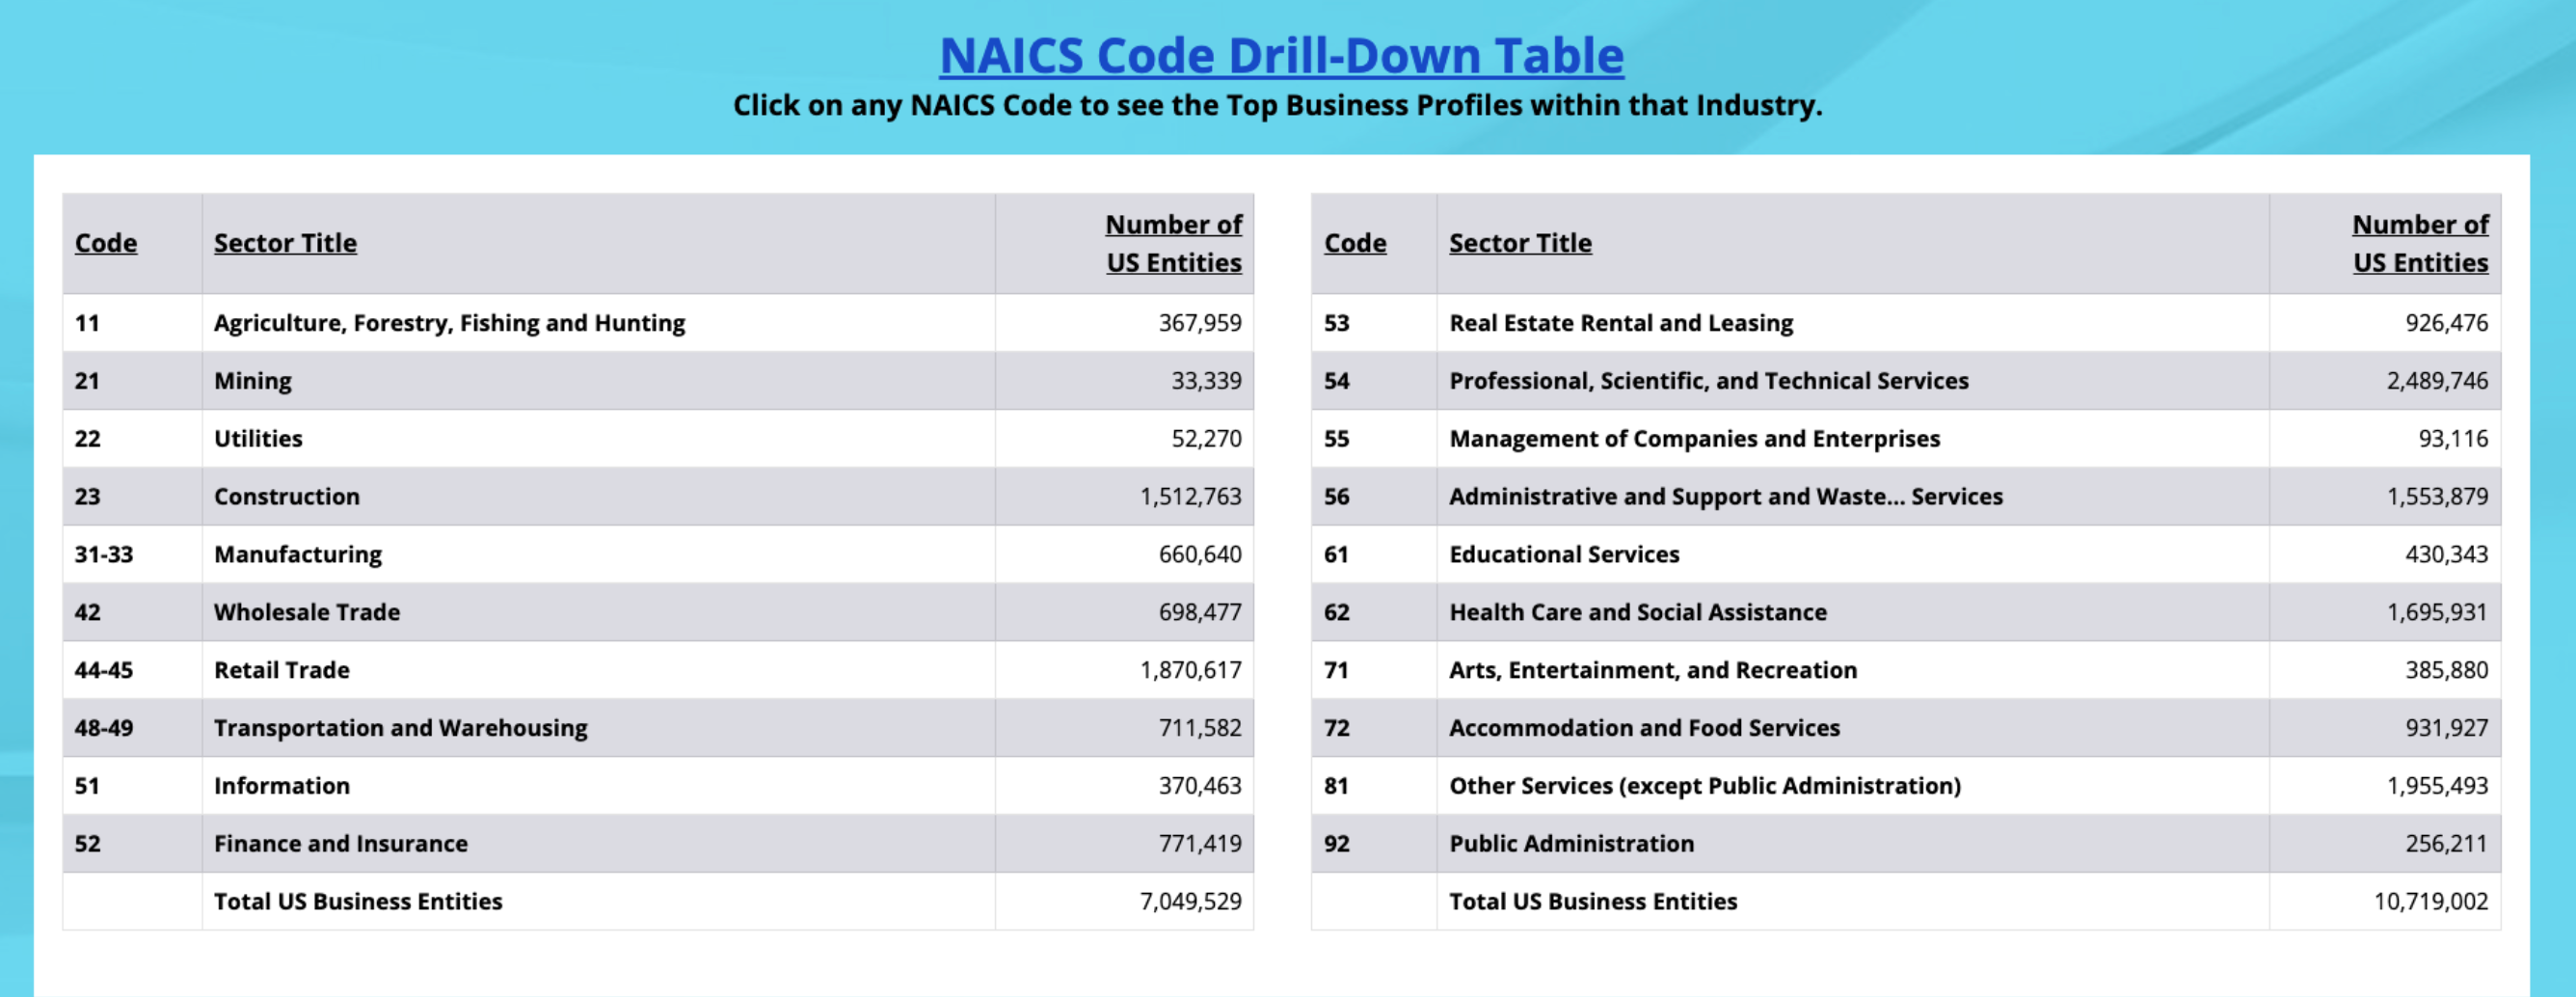

In [34]:
# Dictionnaire pour relier le cdes premiers chifres du code NAIC selon le secteur (voir image dessus)
naics_map = {
    '11': 'Agriculture', '21': 'Mining', '22': 'Utilities', '23': 'Construction',
    '31': 'Manufacturing', '32': 'Manufacturing', '33': 'Manufacturing',
    '42': 'Wholesale', '44': 'Retail', '45': 'Retail',
    '48': 'Transport', '49': 'Transport', '51': 'Information',
    '52': 'Finance', '53': 'Real Estate', '54': 'Prof. Services',
    '55': 'Management', '56': 'Admin/Waste', '61': 'Education',
    '62': 'Health Care', '71': 'Arts/Entertainment', '72': 'Accommodation/Food',
    '81': 'Other Services', '92': 'Public Admin', "in": "Inconnu"
}

# On prend les deux premiers chiffres
df['Industry'] = df['NAICSCode'].astype(str).str[:2]

# On fait le mapping du dico
df['IndustryName'] = df['Industry'].map(naics_map).fillna(df['Industry'])

# On calcule le taux de défaut par industrie
industry_risk = df.groupby('IndustryName')['LoanStatus'].mean().sort_values(ascending=False)

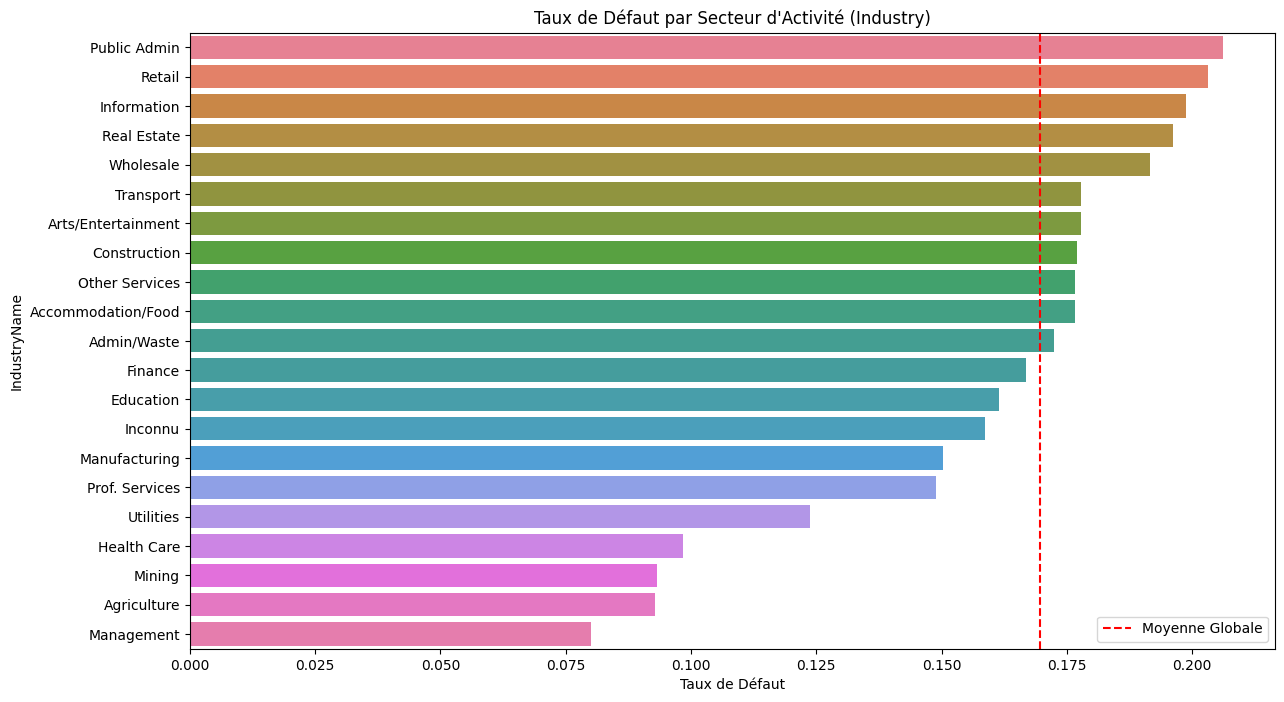

In [35]:
plt.figure(figsize=(14, 8))
sns.barplot(x=industry_risk.values, 
            y=industry_risk.index, 
            hue=industry_risk.index)
plt.title("Taux de Défaut par Secteur d'Activité (Industry)")
plt.xlabel("Taux de Défaut")
plt.axvline(x=df['LoanStatus'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

On voit bien graphiquement que le risque dépend fortement du secteur d'activité avec des secteurs plus risquées que d'autres. Mais il faut faire aussi attention à la significativité de ces chiffres dans l'intérprétation.



In [36]:
# ON voit qu'on a des secteurs qui sont tr!s faiblement représentés
df.IndustryName.value_counts()

IndustryName
Retail                169385
Accommodation/Food    128179
Construction          105177
Prof. Services        102936
Other Services        100298
Manufacturing          84307
Health Care            83130
Wholesale              59113
Admin/Waste            52919
Transport              47126
Arts/Entertainment     25283
Real Estate            22768
Finance                17575
Inconnu                16682
Information            15368
Education              12892
Agriculture            11870
Mining                  2480
Utilities                930
Management               425
Public Admin             194
Name: count, dtype: int64

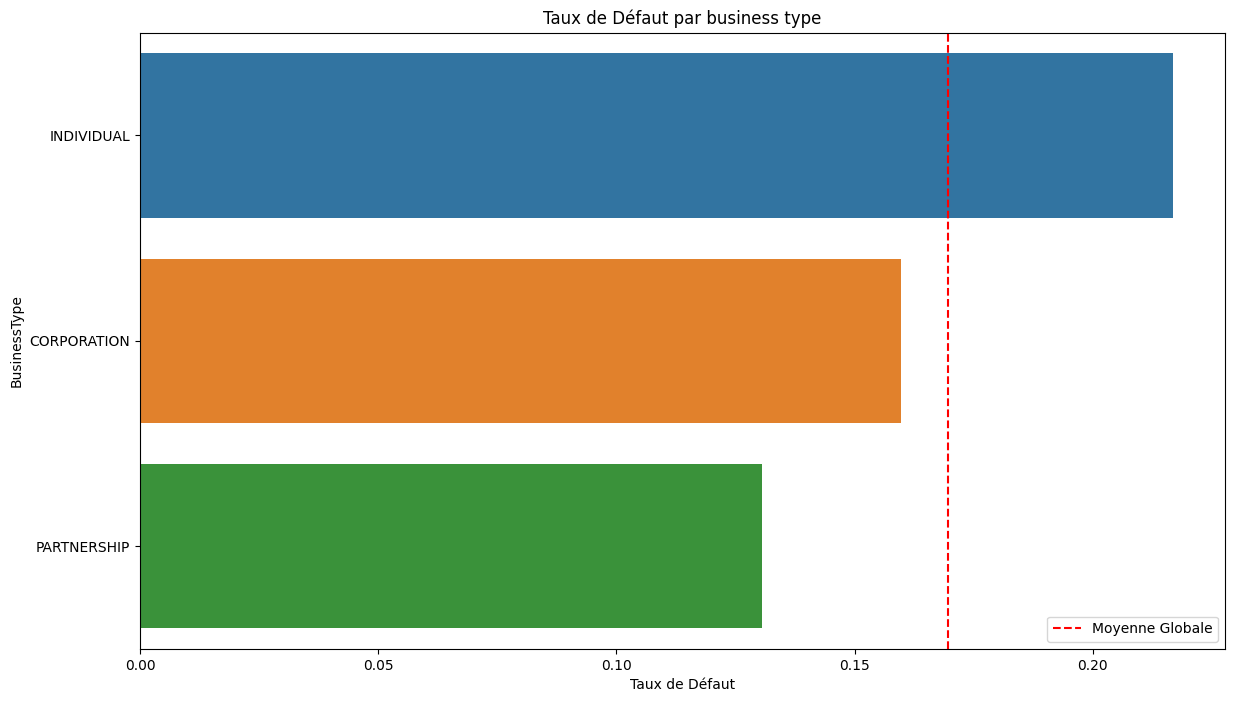

In [37]:
# Taux de défaut selon le businesstype (individuel, corpo, partnership)
business_risk = df.groupby('BusinessType')['LoanStatus'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x=business_risk.values, 
            y=business_risk.index, 
            hue=business_risk.index)
plt.title("Taux de Défaut par business type")
plt.xlabel("Taux de Défaut")
plt.axvline(x=df['LoanStatus'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

La encore on voit que la variable permet de bien différencier le risque, les entreprises individuels semblent bcp plus risquées que les autres types de boites

/var/folders/1j/c4tp9nxx665dfg322ydf_mfw0000gn/T/ipykernel_23157/3523158129.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


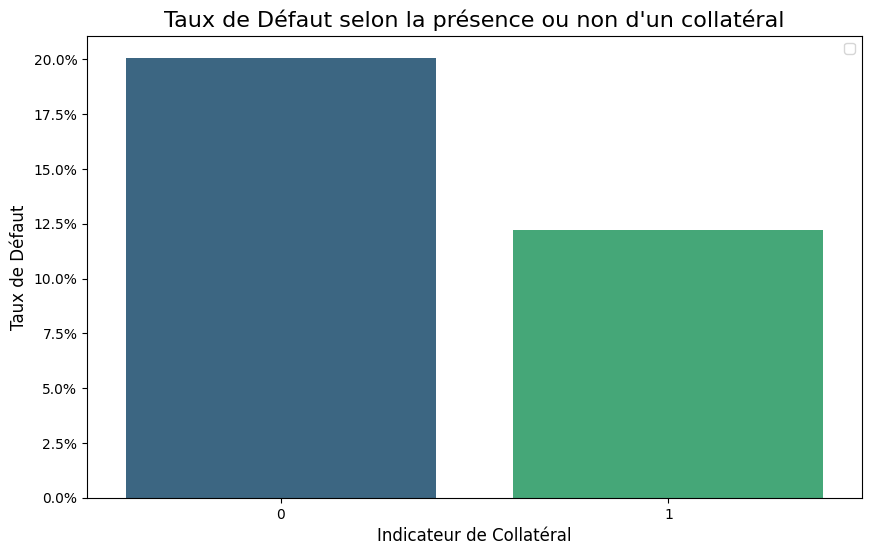

In [38]:
collat_risk = df.groupby('CollateralInd')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6)) # Format un peu plus compact pour des barres verticales
sns.barplot(x=collat_risk.index, 
            y=collat_risk.values, 
            hue=collat_risk.index, 
            legend=False, 
            palette="viridis")

plt.title("Taux de Défaut selon la présence ou non d'un collatéral", fontsize=16)
plt.xlabel("Indicateur de Collatéral", fontsize=12)
plt.ylabel("Taux de Défaut", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.show()

Les prêts sans collatéral sont logiquement plus risqués



## 3.3.1 Variables géographiques


In [39]:
round(df["BorrState"].value_counts(), 5)
# On voit qu'il y des régions avec trop peu d'observations (à voir s'il ne faut pas les regrouper)

BorrState
CA    139267
TX     80789
NY     69885
FL     54337
OH     47626
PA     41114
IL     34903
MA     34520
MI     33741
NJ     31495
MN     29062
GA     27521
WA     27338
WI     25144
CO     24650
UT     23579
AZ     22582
IN     20224
MO     19878
NC     18886
MD     16279
VA     15991
OR     14348
CT     13975
NH     12022
TN     10387
PR     10378
ID     10369
OK     10067
KY      9300
LA      9254
KS      9230
IA      9111
RI      9093
NV      8949
MS      8659
SC      7663
NE      6977
AL      6964
ME      6444
MT      6296
AR      5949
NM      5194
HI      5106
VT      4424
ND      4114
SD      3046
WV      3003
DE      2802
WY      2151
DC      2001
AK      1858
GU       815
VI       234
MP        20
AS        11
PW         6
MH         3
AE         2
FM         1
Name: count, dtype: int64

On a des états avec un nb d'obs très faible, Je pense il faut regrouper lrsq le nb d'obs de l'etat est inf à 100



In [40]:
# ON fait le choix de regrouper à partir de VI dans une catégorie Other
freq = df['BorrState'].value_counts()
state_rares = freq[freq < 239].index
df.loc[df['BorrState'].isin(state_rares), 'BorrState'] = 'Other'

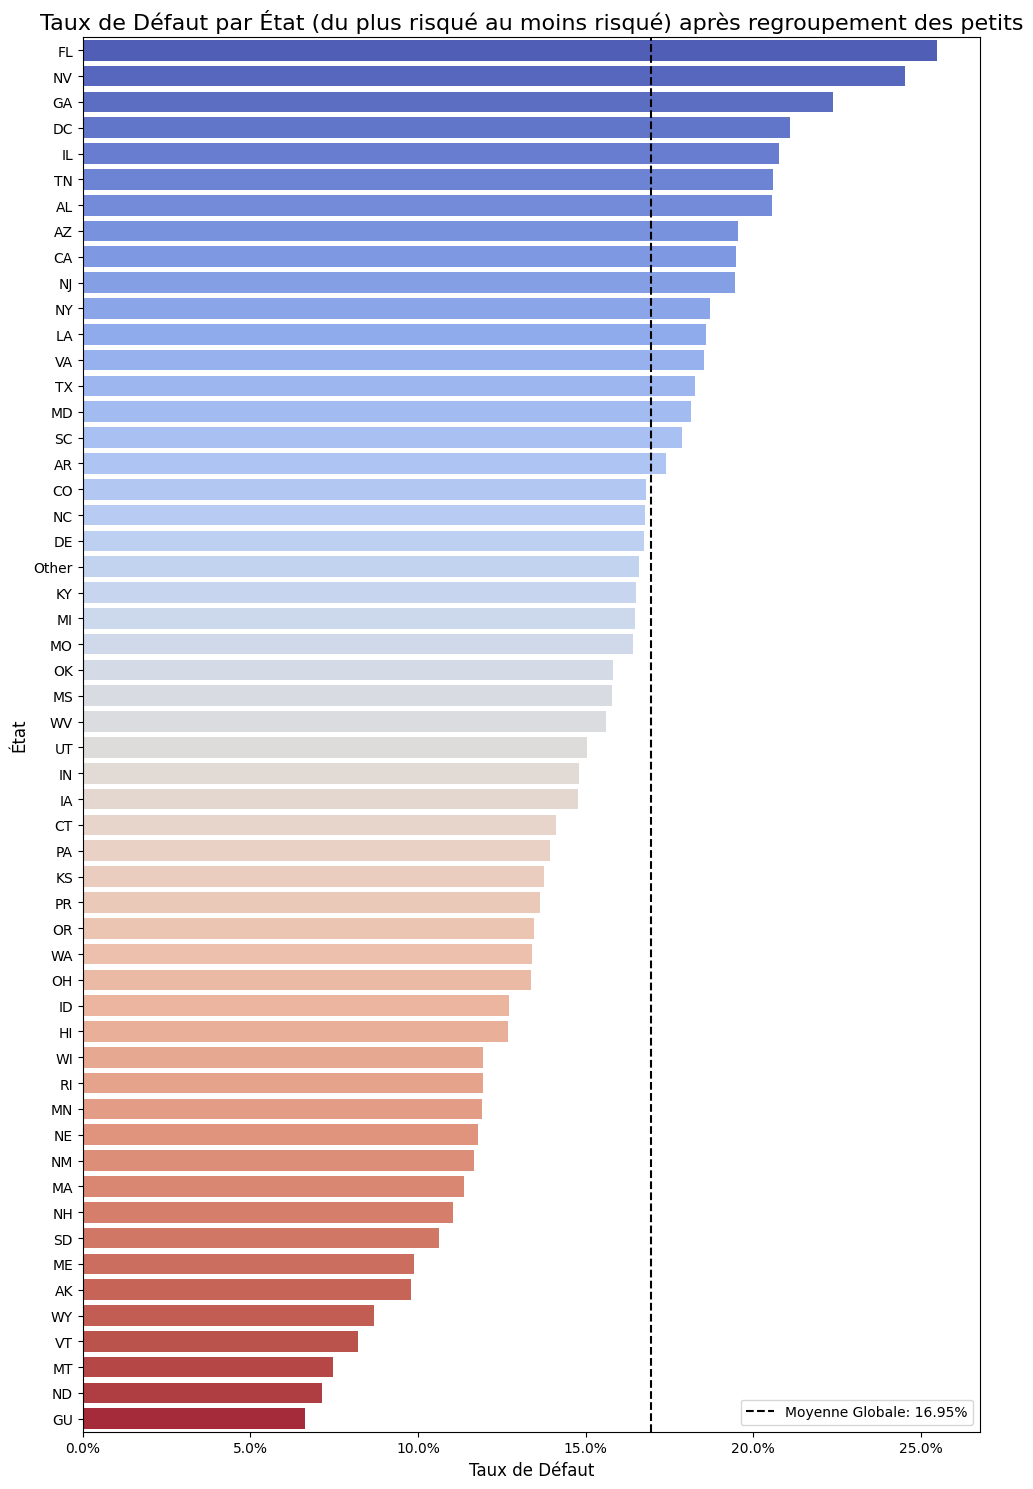

In [41]:
state_risk = df.groupby('BorrState')['LoanStatus'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 15)) 
sns.barplot(x=state_risk.values, 
            y=state_risk.index, 
            hue=state_risk.index, 
            legend=False, 
            palette="coolwarm")

plt.title("Taux de Défaut par État (du plus risqué au moins risqué) après regroupement des petits", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

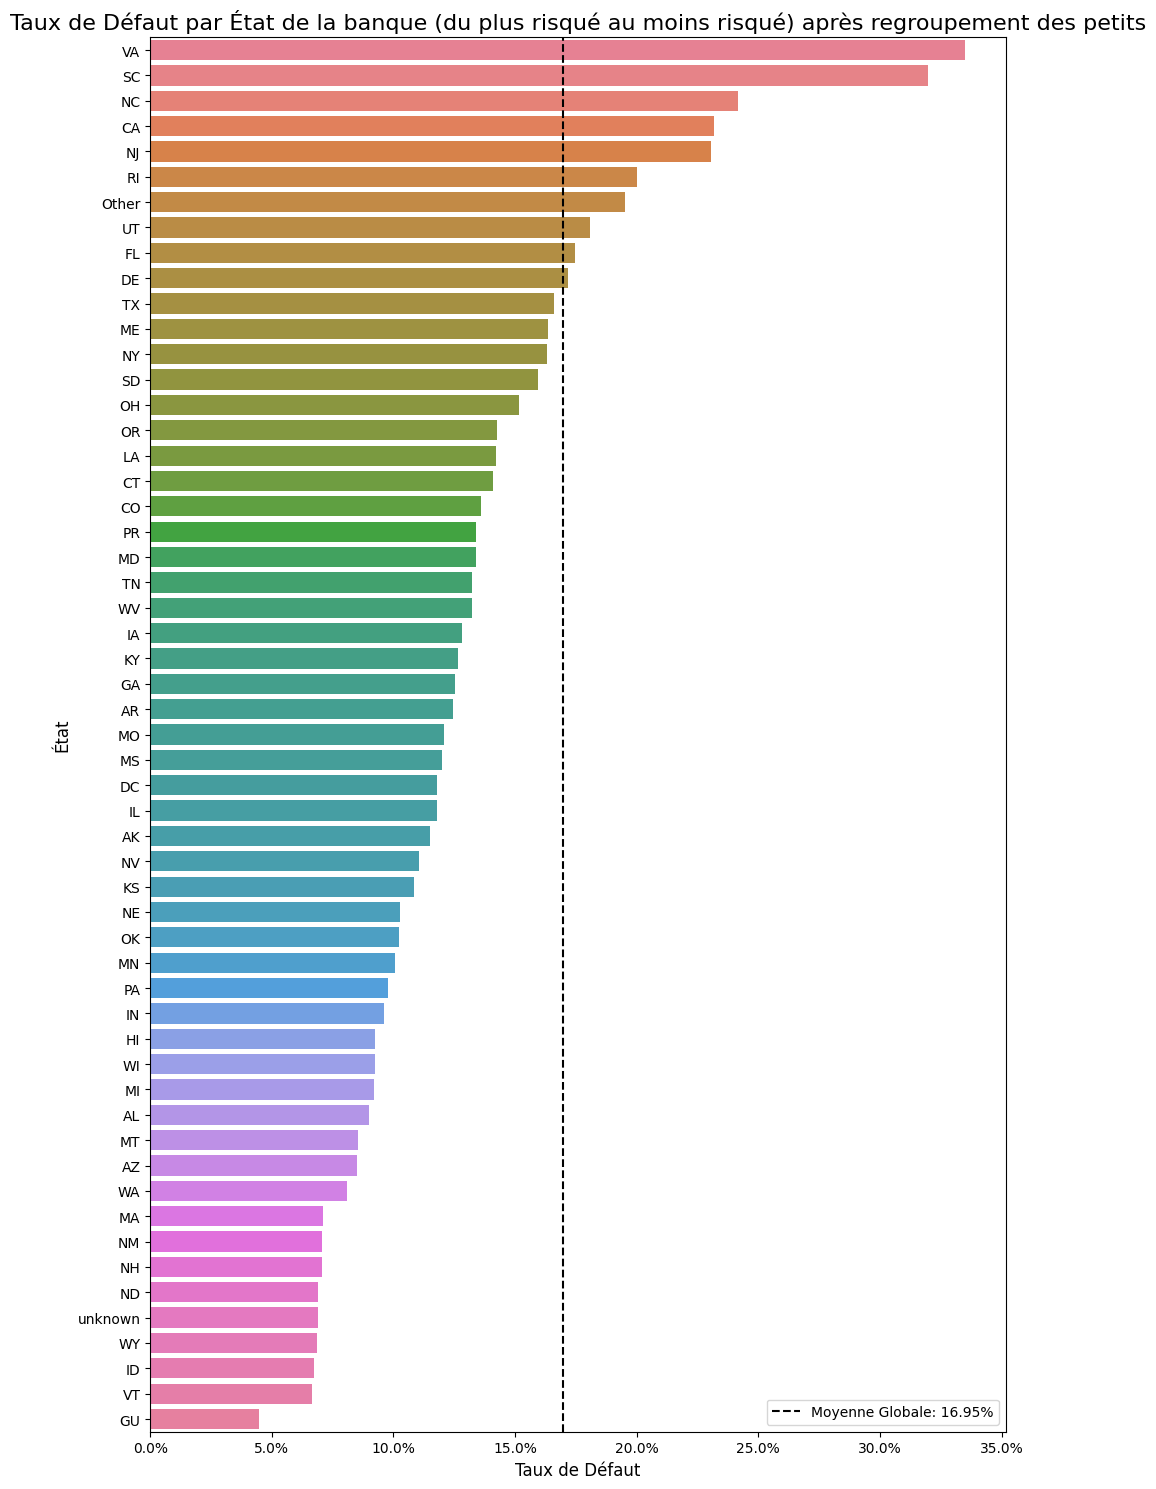

In [42]:
freq = df['BankState'].value_counts()
state_rares = freq[freq < 400].index
df.loc[df['BankState'].isin(state_rares), 'BankState'] = 'Other'

bank_state_risk = df.groupby('BankState')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=bank_state_risk.values, 
            y=bank_state_risk.index, 
            hue=bank_state_risk.index, 
            legend=False)

plt.title("Taux de Défaut par État de la banque (du plus risqué au moins risqué) après regroupement des petits", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

La aussi on voit que selon l'état de la banque on a des taux de défaut très différent



In [43]:
df.ProcessingMethod.value_counts()


ProcessingMethod
SBA Express Program                                             556722
Preferred Lenders Program                                       266712
7a General                                                       82719
Community Express                                                42876
Low Documentation Program                                        41874
Small Loan Advantage Initiative                                  24171
Patriot Express Loans                                             9398
Certified Lenders Program                                         9313
Community Advantage Initiative                                    4478
International Trade Loans                                         4068
Rural Loan Initiative                                             3616
Gulf Opportunity Pilot Loan Program                               2771
Standard Asset Base Working Capital Line of Credit (CAPLine)      2655
Export Express                                              

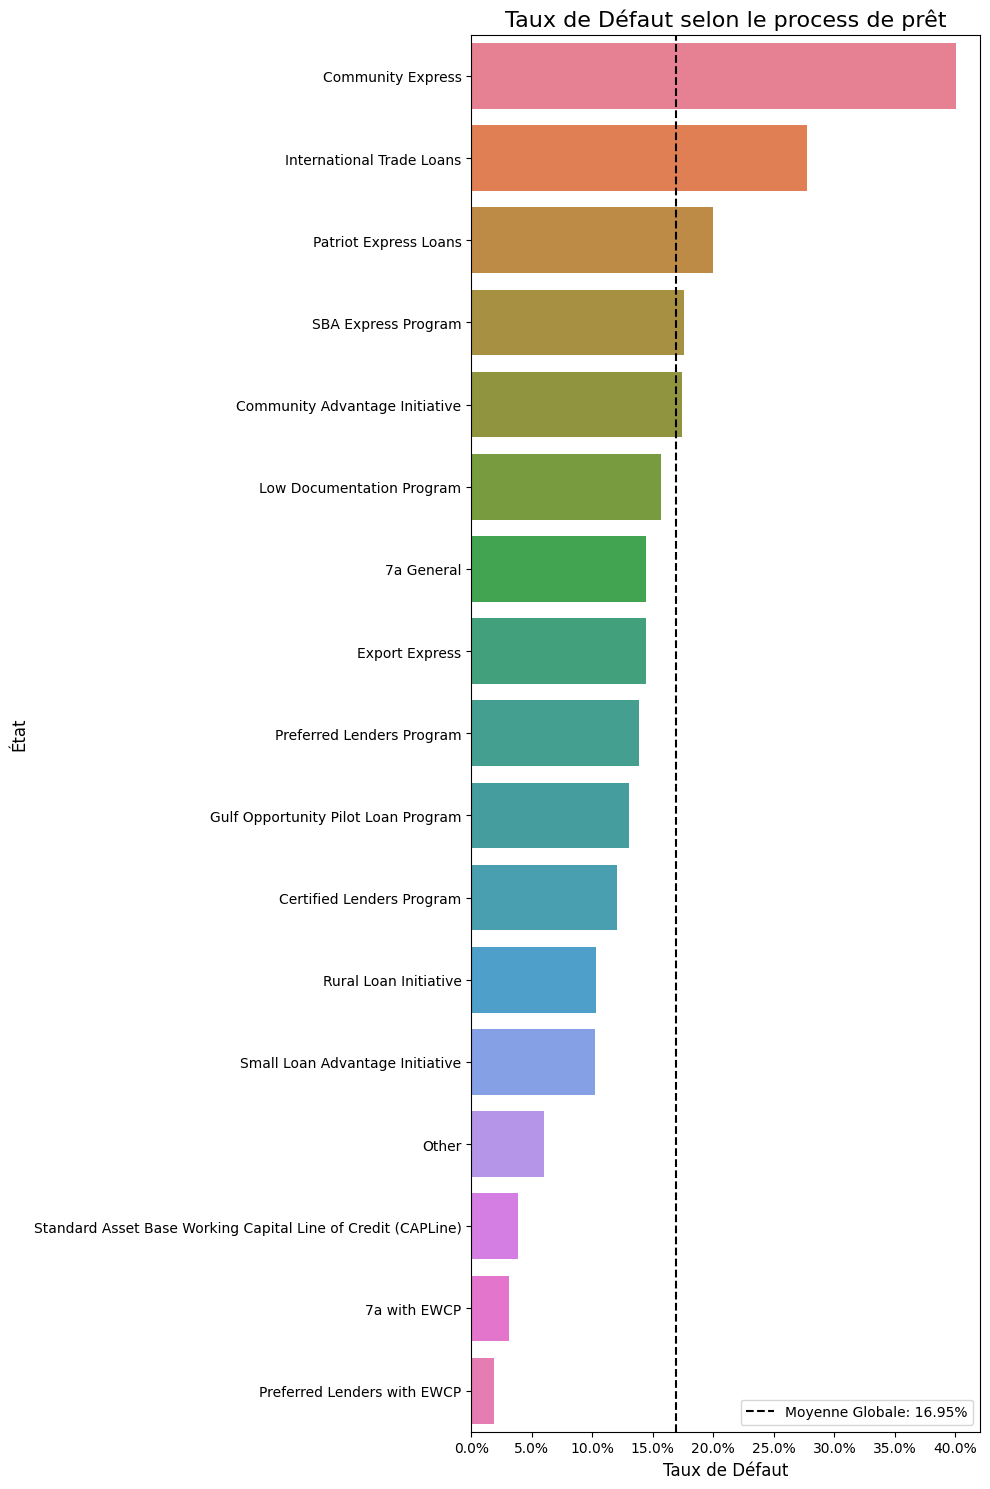

In [44]:
freq = df['ProcessingMethod'].value_counts()
rares = freq[freq < 1000].index
df.loc[df['ProcessingMethod'].isin(rares), 'ProcessingMethod'] = 'Other'
method_risk = df.groupby('ProcessingMethod')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=method_risk.values, 
            y=method_risk.index, 
            hue=method_risk.index, 
            legend=False)

plt.title("Taux de Défaut selon le process de prêt", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

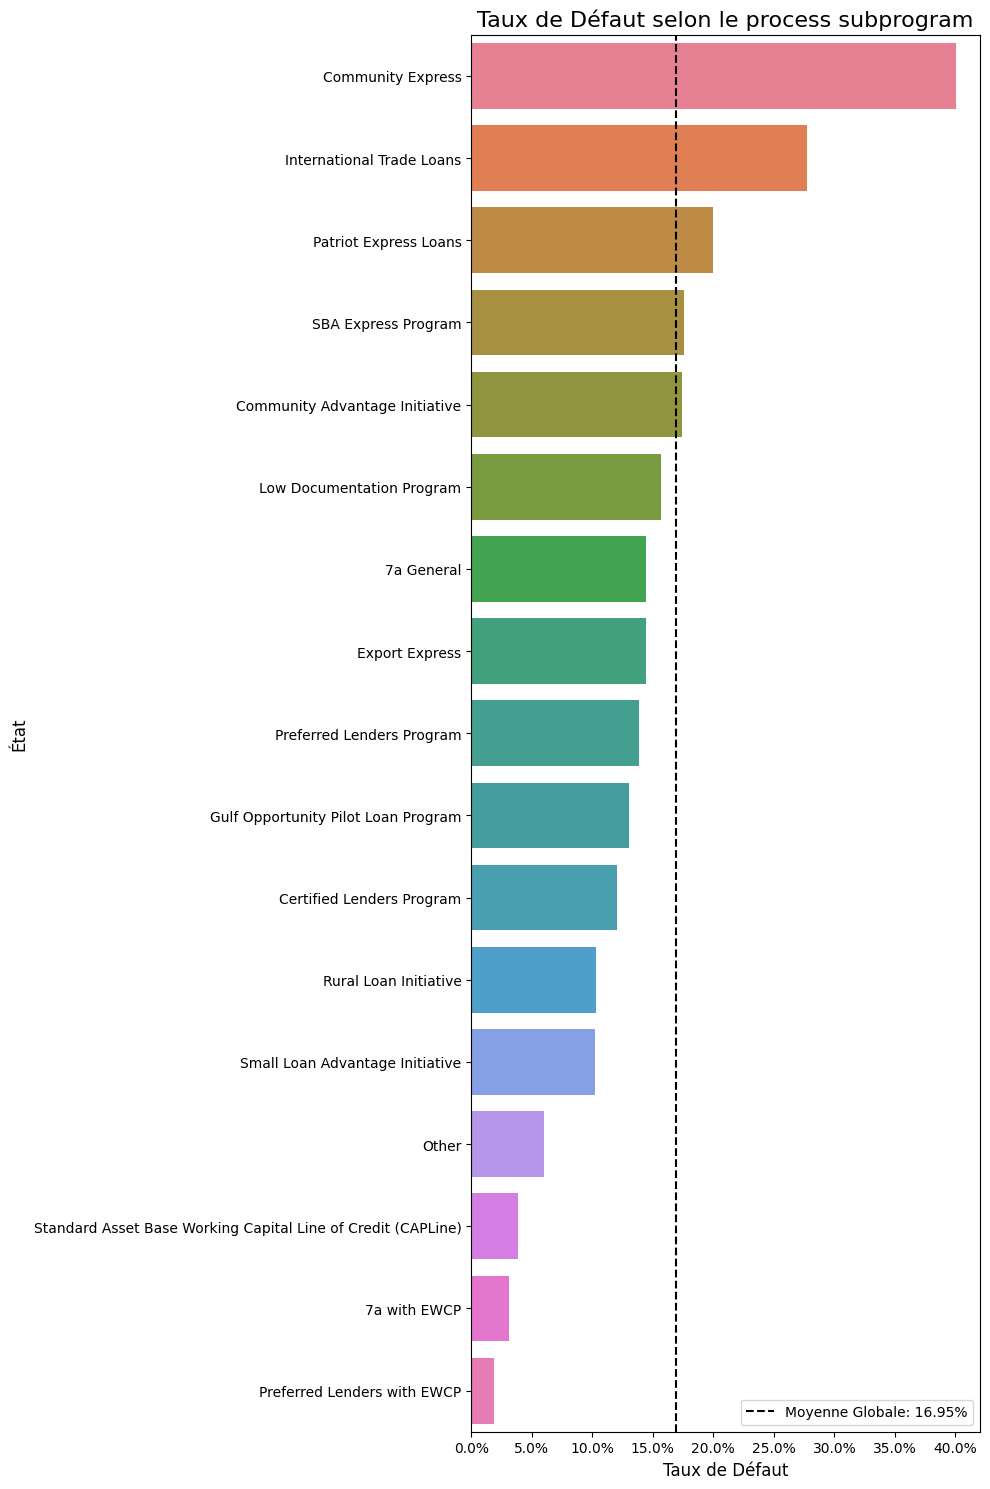

In [45]:
freq = df['Subprogram'].value_counts()
rares = freq[freq < 1000].index
df.loc[df['ProcessingMethod'].isin(rares), 'Subprogram'] = 'Other'
method_risk = df.groupby('ProcessingMethod')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=method_risk.values, 
            y=method_risk.index, 
            hue=method_risk.index, 
            legend=False)

plt.title("Taux de Défaut selon le process subprogram", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

In [46]:
# Taux de défaut selon RevolverStatus
pd.crosstab(df["RevolverStatus"], df["LoanStatus"], normalize="index")

LoanStatus,0,1
RevolverStatus,,
0,0.835366,0.164634
1,0.819437,0.180563


## 3.4 Matrice de corrélation

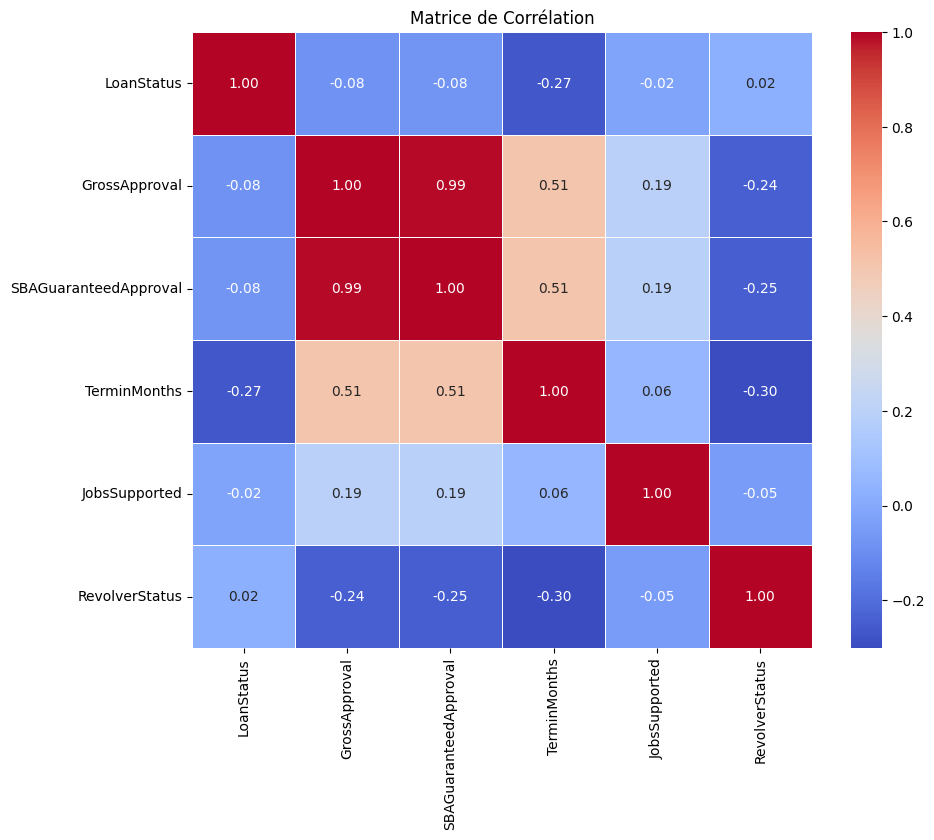

In [47]:
cols_corr = ['LoanStatus', 'GrossApproval', 'SBAGuaranteedApproval', 'TerminMonths', 'JobsSupported', 'RevolverStatus']
corr_matrix = df[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

# 4. DETECTION DES OUTLIERS 

## 4.1 Outliers des variables quantitatives

Au lieu de supprimer les outliers (qui sont porteurs d'information dans ce cadre surtout qu'on en a bcp au vu des boxplot qu'on a vu au dessus) on va plutot faire une transformation logarithmique permettant d'attenuer l'effet des outliers

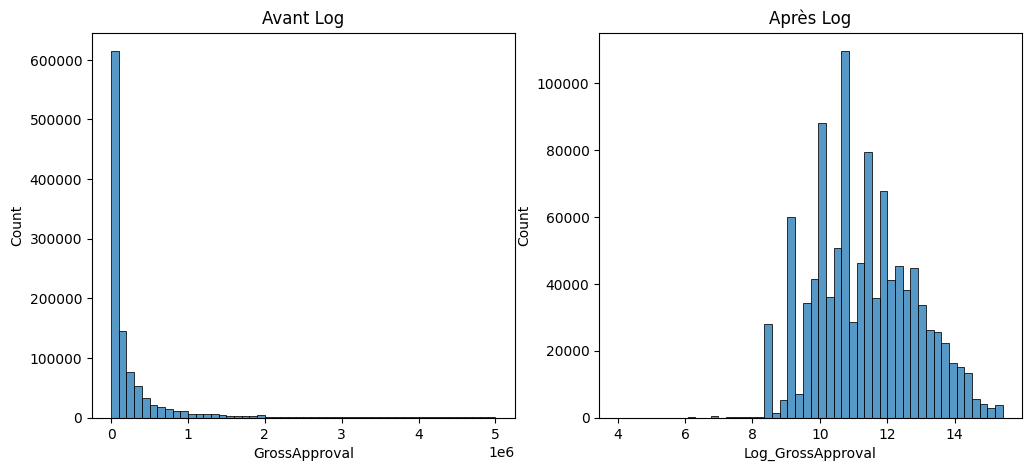

In [48]:
df['Log_GrossApproval'] = np.log1p(df['GrossApproval'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['GrossApproval'], ax=ax[0], bins=50).set_title("Avant Log")
sns.histplot(df['Log_GrossApproval'], ax=ax[1], bins=50).set_title("Après Log")
plt.show()

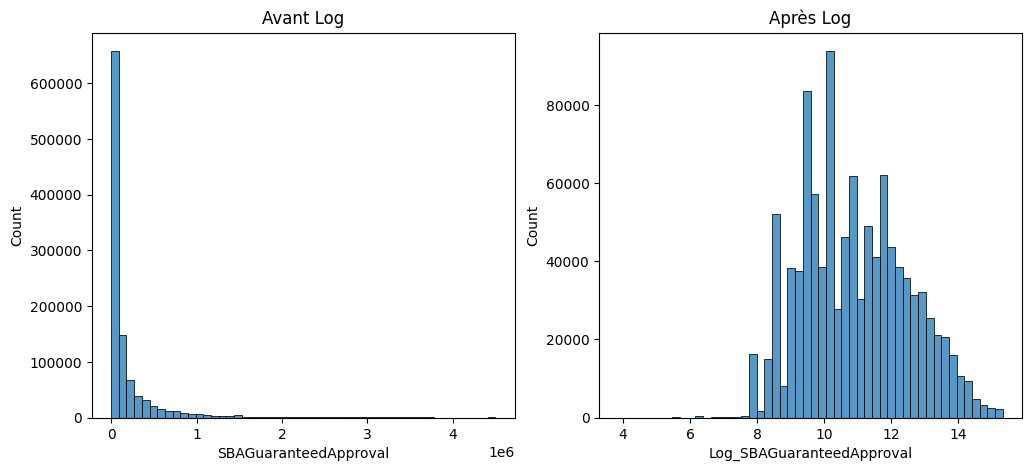

In [49]:
df['Log_SBAGuaranteedApproval'] = np.log1p(df['SBAGuaranteedApproval'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['SBAGuaranteedApproval'], ax=ax[0], bins=50).set_title("Avant Log")
sns.histplot(df['Log_SBAGuaranteedApproval'], ax=ax[1], bins=50).set_title("Après Log")
plt.show()

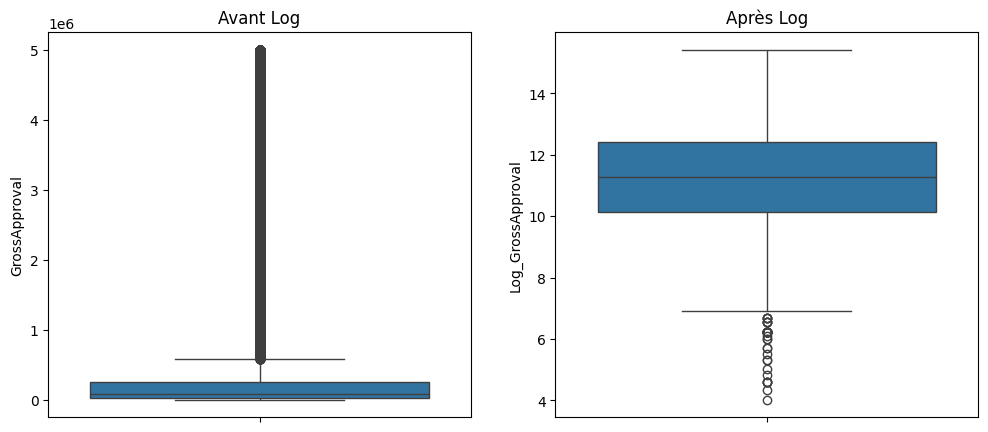

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['GrossApproval'], ax=ax[0]).set_title("Avant Log")
sns.boxplot(df['Log_GrossApproval'], ax=ax[1]).set_title("Après Log")
plt.show()

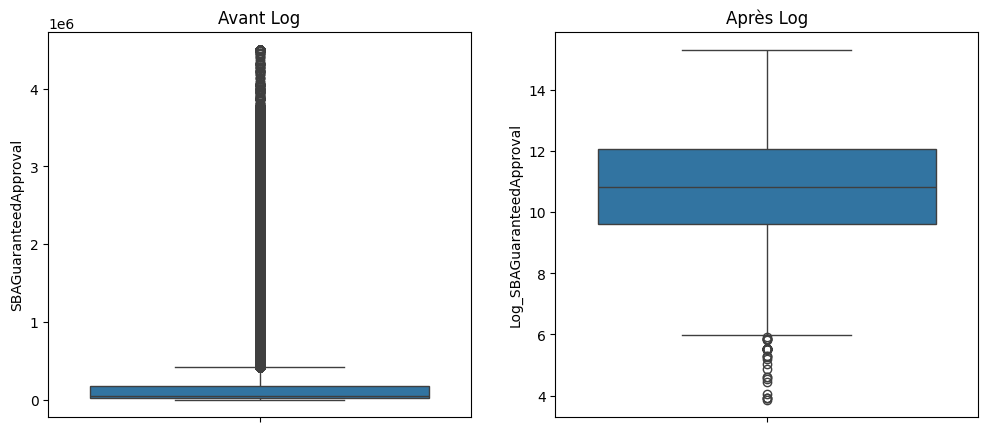

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['SBAGuaranteedApproval'], ax=ax[0]).set_title("Avant Log")
sns.boxplot(df['Log_SBAGuaranteedApproval'], ax=ax[1]).set_title("Après Log")
plt.show()

# 5. Discrétisation 

## 5.1 Discrétisation de "TerminMonths" 

In [52]:
# Les contrats ou on a 0 temps restants
df = df[df["TerminMonths"]!=0]
df['TerminMonths_cut'] = pd.qcut(df["TerminMonths"], q=20, duplicates ='drop')

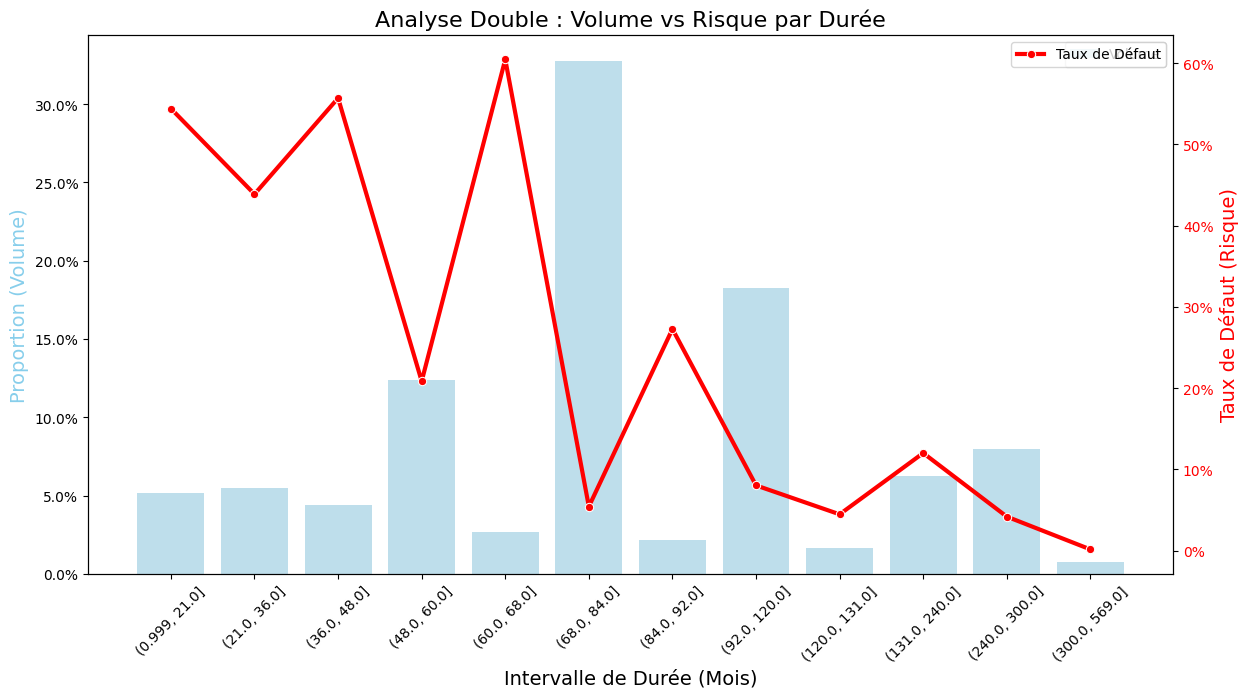

In [53]:
volume = df['TerminMonths_cut'].value_counts(normalize=True).sort_index()
volume.index = volume.index.astype(str) # <--- LA CORRECTION EST ICI

risk = df.groupby('TerminMonths_cut', observed=False)['LoanStatus'].mean().sort_index()
risk.index = risk.index.astype(str)     # <--- ET ICI

fig, ax1 = plt.subplots(figsize=(14, 7))


sns.barplot(x=volume.index, y=volume.values, ax=ax1, color='skyblue', alpha=0.6, label='Volume')
ax1.set_ylabel("Proportion (Volume)", fontsize=14, color='skyblue')
ax1.set_xlabel("Intervalle de Durée (Mois)", fontsize=14)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2 = ax1.twinx()

sns.lineplot(x=risk.index, y=risk.values, ax=ax2, color='red', marker='o', linewidth=3, label='Taux de Défaut')

ax2.set_ylabel("Taux de Défaut (Risque)", fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title("Analyse Double : Volume vs Risque par Durée", fontsize=16)
ax1.tick_params(axis='x', rotation=45) # Rotation des étiquettes

plt.show()

In [54]:
bins_cut = [0, 48, 68, 84, 120, 240, 600] # On est obligé de regrouper 60-68 avec la catégorie précédante car pas assez d'obs mais très diff 

df['TerminMonths_cut'] = pd.cut(df['TerminMonths'], bins=bins_cut)
df['TerminMonths_cut'].value_counts(normalize=True)

TerminMonths_cut
(68, 84]      0.327826
(84, 120]     0.204354
(0, 48]       0.150937
(48, 68]      0.150635
(240, 600]    0.087210
(120, 240]    0.079037
Name: proportion, dtype: float64

In [55]:
df.groupby('TerminMonths_cut').agg({'LoanStatus' : "mean"})


/var/folders/1j/c4tp9nxx665dfg322ydf_mfw0000gn/T/ipykernel_23157/1048035336.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('TerminMonths_cut').agg({'LoanStatus' : "mean"})


,LoanStatus
TerminMonths_cut,
"(0, 48]",0.509353
"(48, 68]",0.279497
"(68, 84]",0.054225
"(84, 120]",0.100540
"(120, 240]",0.104406
"(240, 600]",0.038477


## 5.2 Discrétisation de "JobsSupported"

In [56]:
df["JobsSupported_cut"] = pd.qcut(df["JobsSupported"], q=20, duplicates='drop')

In [57]:
df.groupby("JobsSupported_cut").agg({"LoanStatus" : "mean",
                                    "JobsSupported" : "count"})

/var/folders/1j/c4tp9nxx665dfg322ydf_mfw0000gn/T/ipykernel_23157/2790225200.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("JobsSupported_cut").agg({"LoanStatus" : "mean",


,LoanStatus,JobsSupported
JobsSupported_cut,,
"(-0.001, 1.0]",0.154380,287627
"(1.0, 2.0]",0.176628,120672
"(2.0, 3.0]",0.200156,85973
"(3.0, 4.0]",0.193024,83492
"(4.0, 5.0]",0.197073,63824
"(5.0, 6.0]",0.189410,56222
"(6.0, 8.0]",0.184717,73729
"(8.0, 10.0]",0.169622,57410
"(10.0, 12.0]",0.169068,37902


In [58]:
bins_jobs = [-0.001, 2, 3, 8, 10, 20, 99999]

df['JobsSupported_cut'] = pd.cut(df['JobsSupported'], bins=bins_jobs)
df['JobsSupported_cut'].value_counts(normalize=True)

JobsSupported_cut
(-0.001, 2.0]      0.385942
(3.0, 8.0]         0.262085
(10.0, 20.0]       0.117655
(20.0, 99999.0]    0.098786
(2.0, 3.0]         0.081265
(8.0, 10.0]        0.054266
Name: proportion, dtype: float64

# 6. Feature engineering

In [59]:
df.columns

Index(['BorrState', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd',
       'Industry', 'IndustryName', 'Log_GrossApproval',
       'Log_SBAGuaranteedApproval', 'TerminMonths_cut', 'JobsSupported_cut'],
      dtype='object')

In [60]:
df = df.reset_index()

In [61]:
# On crée un décalage de un an pour calculer nos variables sans mettre un biais temporel dans le modèle
df["year"] = df.ApprovalDate.dt.year
df["year_lag"] = df["year"] - 1

# Statistiques globales sur une année aux Eu
stats_usa = df.groupby('year')['GrossApproval'].agg(emprunts_us_tot='sum',
                                                          emprunts_us_med='median',
                                                          emprunts_us_mean='mean').reset_index()

# Statistiques calculées selon l'état géographique de l'emprunteur (par an)
stats_borr_state = df.groupby(['year', 'BorrState'])['GrossApproval'].agg(emprunt_state_tot='sum',
                                                                                emprunt_state_med='median',
                                                                                emprunt_state_mean='mean').reset_index()

# Statistiques calculées selon le secteur d'activité de l'entreprise emprunteur (par an)
stats_industry = df.groupby(['year', 'IndustryName'])['GrossApproval'].agg(emprunt_industry_tot='sum',
                                                                                 emprunt_industry_med='median',
                                                                                 emprunt_industry_mean='mean').reset_index()

df = df.merge(stats_usa, left_on='year_lag', right_on='year', how='left')
df = df.merge(stats_borr_state, left_on=['year_lag', 'BorrState'], right_on=['year', 'BorrState'], how='left', suffixes=('', '_drop'))
df = df.merge(stats_industry, left_on=['year_lag', 'IndustryName'], right_on=['year', 'IndustryName'], how='left', suffixes=('', '_drop'))

drop_cols = [col for col in df.columns if 'drop' in col]
df = df.drop(columns=drop_cols)
df = df.dropna() # Pour la premiière année 

# Ratios basées sur les variables calculées ci-dessus
df['taille_emprunt_vs_state_med'] = df['GrossApproval'] / (df['emprunt_state_med'] + 1)
df['taille_emprunt__vs_industry_med'] = df['GrossApproval'] / (df['emprunt_industry_med'] + 1)
df['taille_emprunt_vs_us_med'] = df['GrossApproval'] / (df['emprunts_us_med'] + 1)

df['delta_emprunt_vs_state_mean'] = df['GrossApproval'] - df['emprunt_state_mean']
df['delta_emprunt_vs_industry_mean'] = df['GrossApproval'] - df['emprunt_industry_mean']

df['part_emprunt_vs_state'] = df['GrossApproval'] / (df['emprunt_state_tot'] + 1)
df['part_emprunt_vs_industry'] = df['GrossApproval'] / (df['emprunt_industry_tot'] + 1)

df['taille_relative_state_vs_etat'] = df['emprunt_state_tot'] / (df['emprunts_us_tot'] + 1)
df['taille_relative_industry_vs_etat'] = df['emprunt_industry_tot'] / (df['emprunts_us_tot'] + 1)

# Ratio loan vs garantie sba
df["ratio_loan_guarantee"] = df["SBAGuaranteedApproval"] / df["GrossApproval"]

## 6.1 Variables macroéconomiques

In [62]:
gdp = pd.read_csv("data/GDP.csv")
spread = pd.read_csv("data/T10Y2Y.csv")
inflation = pd.read_csv("data/CPIAUCSL.csv")

In [63]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  103 non-null    object 
 1   CPIAUCSL          103 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [64]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  26 non-null     object 
 1   GDP               25 non-null     float64
dtypes: float64(1), object(1)
memory usage: 548.0+ bytes


In [65]:
spread.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  104 non-null    object 
 1   T10Y2Y            103 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [66]:
gdp["observation_date"] = pd.to_datetime(gdp["observation_date"])
spread["observation_date"] = pd.to_datetime(spread["observation_date"])
inflation["observation_date"] = pd.to_datetime(inflation["observation_date"])

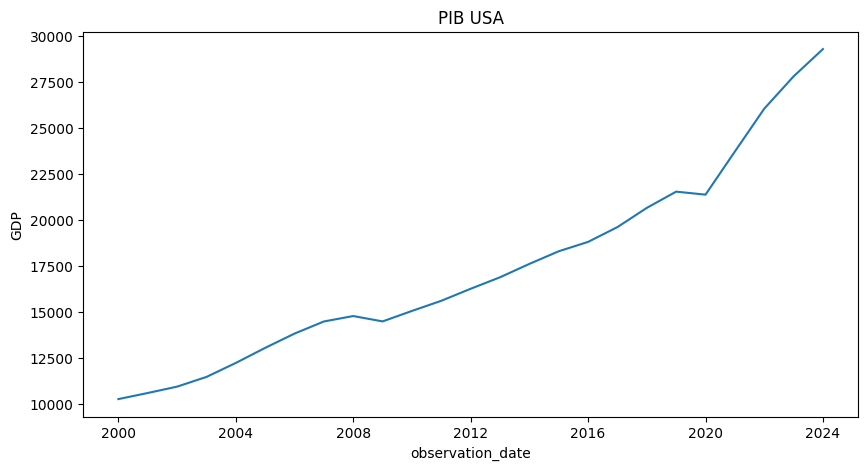

In [67]:
plt.figure(figsize=(10, 5))
sns.lineplot(gdp.set_index("observation_date")["GDP"])
plt.title("PIB USA")
plt.show()

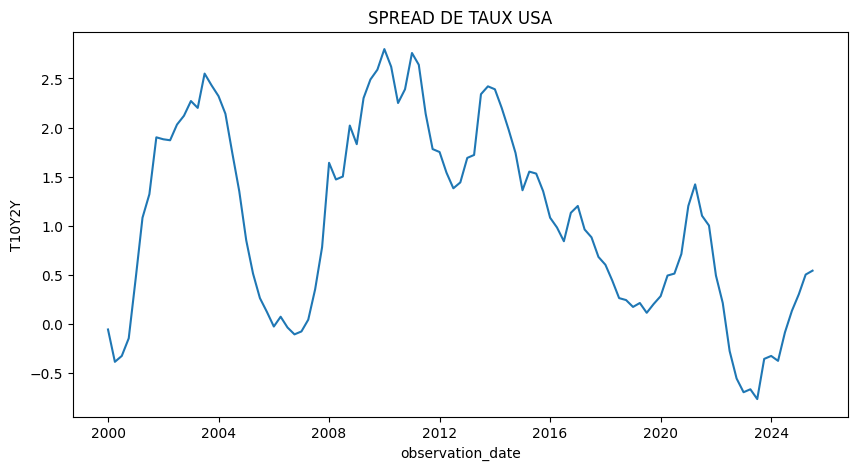

In [68]:
plt.figure(figsize=(10, 5))
sns.lineplot(spread.set_index("observation_date")["T10Y2Y"])
plt.title("SPREAD DE TAUX USA")
plt.show()

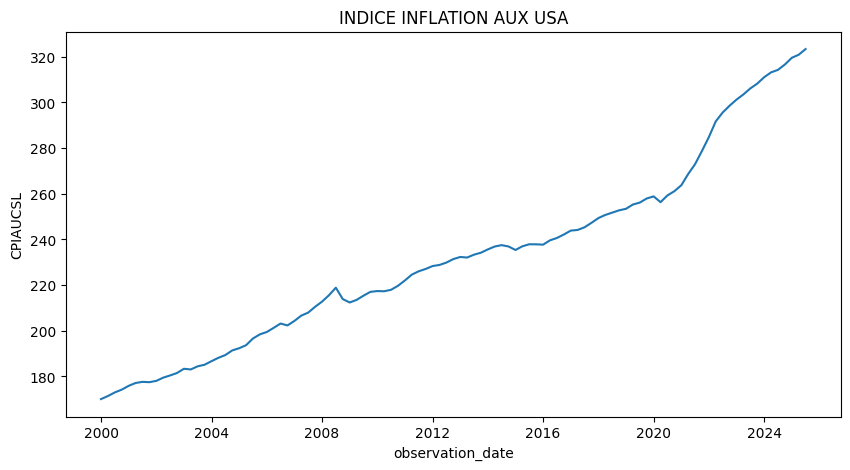

In [69]:
plt.figure(figsize=(10, 5))
sns.lineplot(inflation.set_index("observation_date")["CPIAUCSL"])
plt.title("INDICE INFLATION AUX USA")
plt.show()

In [70]:
gdp["year"] = gdp.observation_date.dt.year
gdp["Croissance_PIB"] = gdp["GDP"].pct_change() # Variation p/r année précédente
gdp["Croissance_PIB_lag1"] = gdp["Croissance_PIB"].shift(1)
gdp = gdp[["year", "Croissance_PIB_lag1"]]

/var/folders/1j/c4tp9nxx665dfg322ydf_mfw0000gn/T/ipykernel_23157/2599296831.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  gdp["Croissance_PIB"] = gdp["GDP"].pct_change() # Variation p/r année précédente


In [71]:
spread["Year_Quarter"] = spread.observation_date.dt.to_period('Q')
spread["variation_spread"] = spread["T10Y2Y"].pct_change() # variation p/r trimestre pré
spread["T10Y2Y_variation_Lag1"] = spread["variation_spread"].shift(1)
spread["T10Y2Y_variation_Lag2"] = spread["variation_spread"].shift(2)
spread["T10Y2Y_Lag1"] = spread["T10Y2Y"].shift(1)
spread["T10Y2Y_Lag2"] = spread["T10Y2Y"].shift(2)
spread = spread[["Year_Quarter", "T10Y2Y_variation_Lag1", "T10Y2Y_variation_Lag2", "T10Y2Y_Lag1", "T10Y2Y_Lag2"]]

/var/folders/1j/c4tp9nxx665dfg322ydf_mfw0000gn/T/ipykernel_23157/300812893.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  spread["variation_spread"] = spread["T10Y2Y"].pct_change() # variation p/r trimestre pré


In [72]:
inflation["Year_Quarter"] = inflation.observation_date.dt.to_period('Q')
inflation["variation_inflation_trimestre"] = inflation["CPIAUCSL"].pct_change(1) # variation p/r trimestre pré
inflation["variation_inflation_annee"] = inflation["CPIAUCSL"].pct_change(4) # variation p/r trimestre pré
inflation["Inflation_variation_Lag1_Trimestre"] = inflation["variation_inflation_trimestre"].shift(1)
inflation["Inflation_variation_Lag2_Trimestre"] = inflation["variation_inflation_trimestre"].shift(2)
inflation["Inflation_variation_Lag1_Annee"] = inflation["variation_inflation_annee"].shift(1)
inflation["Inflation_variation_Lag2_Annee"] = inflation["variation_inflation_annee"].shift(2)
inflation = inflation[["Year_Quarter", "Inflation_variation_Lag1_Trimestre","Inflation_variation_Lag2_Trimestre", "Inflation_variation_Lag1_Annee", "Inflation_variation_Lag2_Annee"]]

In [73]:
df["Year_Quarter"] = df.ApprovalDate.dt.to_period('Q')
df = pd.merge(df, spread, how="left", on="Year_Quarter")
df = pd.merge(df, inflation, how = 'left', on = "Year_Quarter")
df = pd.merge(df, gdp, how="left", on="year")

In [74]:
df = df.drop([col for col in df.columns if "_x" in col], axis =1)
df= df.drop([col for col in df.columns if "_y" in col], axis=1) 

In [75]:
df["diff_premier_paiement_vs_approval_date"] = (df["FirstDisbursementDate"]-df['ApprovalDate']).dt.days

In [76]:
df.columns

Index(['ApprovalDate', 'BorrState', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd',
       'Industry', 'IndustryName', 'Log_GrossApproval',
       'Log_SBAGuaranteedApproval', 'TerminMonths_cut', 'JobsSupported_cut',
       'year_lag', 'emprunts_us_tot', 'emprunts_us_med', 'emprunts_us_mean',
       'year', 'emprunt_state_tot', 'emprunt_state_med', 'emprunt_state_mean',
       'emprunt_industry_tot', 'emprunt_industry_med', 'emprunt_industry_mean',
       'taille_emprunt_vs_state_med', 'taille_emprunt__vs_industry_med',
       'taille_emprunt_vs_us_med', 'delta_emprunt_vs_state_mean',
       'delta_emprunt_vs_industry_mean', 'part_emprunt_vs_state',
       'part_emprunt_vs_industry', 'taille_relative_state

# 7. Préparation pour la modélisation

In [77]:
data = df.drop(columns={"ProcessingMethod",
                #"FirstDisbursementDate",
                "NAICSCode",
                "ProjectCounty",
                "Industry",
                "Year_Quarter", 
                "year", 
                "TerminMonths",
                        "year_lag", 'BankState',#"TerminMonths_cut",
                        "BankName", "BorrState"
                       })

In [78]:
data.shape 

(1049518, 47)

In [79]:
data = data[(data["ApprovalDate"] > "2021-01-01") & (data["ApprovalDate"] < "2024-12-31")]

In [80]:
data.groupby([data["ApprovalDate"].dt.year])["LoanStatus"].value_counts(normalize=True)

ApprovalDate  LoanStatus
2021          0             0.942036
              1             0.057964
2022          0             0.877802
              1             0.122198
2023          0             0.868824
              1             0.131176
2024          0             0.953111
              1             0.046889
Name: proportion, dtype: float64

In [81]:
#development = data[data["ApprovalDate"] < "2023-01-01"] # Pour la contruction de train/test
#OOT = data[(data["ApprovalDate"] >= "2023-01-01") & (data["ApprovalDate"]<"2024-12-12")] # Pour la validation temporelle du modèle out of time

In [82]:
#development = development.set_index("ApprovalDate")
#OOT = OOT.set_index("ApprovalDate")

In [83]:
#development = development.drop([col for col in OOT.columns if "ApprovalFY" in col], axis=1)
#OOT = OOT.drop([col for col in OOT.columns if "ApprovalFY" in col], axis=1)

In [84]:
#development.index.max()

In [85]:
#development.index.min()

## 7.1 Découpage train/test/oot temporel

In [86]:
n_total = len(data)
idx_train_end = int(n_total * 0.70)
idx_test_end  = int(n_total * 0.85)

train = data.iloc[:idx_train_end]
test  = data.iloc[idx_train_end:idx_test_end]
oot   = data.iloc[idx_test_end:]


X_train = train.drop('LoanStatus', axis=1)
y_train = train['LoanStatus']

X_test  = test.drop('LoanStatus', axis=1)
y_test  = test['LoanStatus']

X_oot   = oot.drop('LoanStatus', axis=1)
y_oot   = oot['LoanStatus']

print(f"Période Train : {train['ApprovalDate'].min()} à {train['ApprovalDate'].max()}")
print(f"Période Test  : {test['ApprovalDate'].min()} à {test['ApprovalDate'].max()}")
print(f"Période OOT   : {oot['ApprovalDate'].min()} à {oot['ApprovalDate'].max()}")

Période Train : 2021-01-03 00:00:00 à 2022-09-26 00:00:00
Période Test  : 2022-09-26 00:00:00 à 2023-06-13 00:00:00
Période OOT   : 2023-06-13 00:00:00 à 2024-12-30 00:00:00


In [87]:
#development.shape

In [88]:
#OOT.shape

In [89]:
#development.LoanStatus.value_counts(normalize=True )

In [90]:
#OOT.LoanStatus.value_counts(normalize=True )

In [91]:
#development = development.sort_index()
#n = development.shape[0]
#cut = int(n * 0.75)
#train = development.iloc[:cut]
#test  = development.iloc[cut:]

In [92]:
train.LoanStatus.value_counts(normalize=True)

LoanStatus
0    0.923627
1    0.076373
Name: proportion, dtype: float64

In [93]:
test.LoanStatus.value_counts(normalize=True)

LoanStatus
0    0.853674
1    0.146326
Name: proportion, dtype: float64

In [94]:
y_oot.value_counts(normalize=True)

LoanStatus
0    0.918725
1    0.081275
Name: proportion, dtype: float64

## 7.2 Encodage des variables catégorielles 

In [95]:
cat_cols = [
    'ProjectState', 
    'SBADistrictOffice', 
    'IndustryName',
    'Subprogram', 
    'BusinessType', 
    'RevolverStatus',       
    'CollateralInd',        
    'TerminMonths_cut',     
    'JobsSupported_cut'
]
binning_process = {}

X_train_woe = X_train.copy()
X_test_woe  = X_test.copy()
X_oot_woe   = X_oot.copy()

for col in cat_cols:
    
    optb = OptimalBinning(
        name=col,
        dtype="categorical",
        solver="cp",            
        min_bin_size=0.05,      
        max_n_bins=8,           
        min_bin_n_event=5       
    )

    optb.fit(X_train[col], y_train)
    
    binning_process[col] = optb
    
    X_train_woe[col] = optb.transform(X_train[col], metric="woe")
    X_test_woe[col]  = optb.transform(X_test[col], metric="woe")
    X_oot_woe[col]   = optb.transform(X_oot[col], metric="woe")

In [96]:
X_train = X_train_woe.copy()
X_test = X_test_woe.copy()
X_oot = X_oot_woe.copy()

In [97]:
#X_train = train.drop("LoanStatus", axis=1)
#X_test = test.drop("LoanStatus", axis=1)
#y_train= train.LoanStatus
#y_test = test.LoanStatus
#X_oot = OOT.drop("LoanStatus", axis=1)
#y_oot = OOT.LoanStatus

In [98]:
X_train.select_dtypes("object").columns

Index([], dtype='object')

In [99]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22102 entries, 1017743 to 1039844
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   ApprovalDate                            22102 non-null  datetime64[ns]
 1   GrossApproval                           22102 non-null  float64       
 2   SBAGuaranteedApproval                   22102 non-null  float64       
 3   ApprovalFY                              22102 non-null  int64         
 4   FirstDisbursementDate                   22102 non-null  datetime64[ns]
 5   Subprogram                              22102 non-null  float64       
 6   ProjectState                            22102 non-null  float64       
 7   SBADistrictOffice                       22102 non-null  float64       
 8   BusinessType                            22102 non-null  float64       
 9   RevolverStatus                          22102 n

In [100]:
numeric_features = [
    'GrossApproval', 'SBAGuaranteedApproval', 
    #'JobsSupported', 
    'emprunts_us_tot', 'emprunts_us_med', 'emprunts_us_mean',
    'emprunt_state_tot', 'emprunt_state_med', 'emprunt_state_mean',
    'emprunt_industry_tot', 'emprunt_industry_med', 'emprunt_industry_mean',
    'taille_emprunt_vs_state_med', 'taille_emprunt__vs_industry_med', 'taille_emprunt_vs_us_med',
    'delta_emprunt_vs_state_mean', 'delta_emprunt_vs_industry_mean',
    'part_emprunt_vs_state', 'part_emprunt_vs_industry',
    'taille_relative_state_vs_etat', 'taille_relative_industry_vs_etat',
    'ratio_loan_guarantee',
    'T10Y2Y_variation_Lag1', 'T10Y2Y_variation_Lag2', 'T10Y2Y_Lag1', 'T10Y2Y_Lag2',
    'Inflation_variation_Lag1_Trimestre', 'Inflation_variation_Lag2_Trimestre',
    'Inflation_variation_Lag1_Annee', 'Inflation_variation_Lag2_Annee',
    'Croissance_PIB_lag1',
    'diff_premier_paiement_vs_approval_date'
]
categorical_high_card = [
    'ProjectState', 
    'SBADistrictOffice', 
    'IndustryName', 
]

categorical_low_card = [
    'Subprogram', 
    'BusinessType', 
    'RevolverStatus',      
    'CollateralInd',       
    #'TerminMonths_cut',    
    #'JobsSupported_cut'    
]

all_numeric_features = numeric_features + categorical_high_card + categorical_low_card

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), all_numeric_features)
    ],
    verbose_feature_names_out=False
).set_output(transform="pandas")


X_train_encoded = preprocessor.fit_transform(X_train_woe, y_train)
X_test_encoded  = preprocessor.transform(X_test_woe)
X_oot_encoded   = preprocessor.transform(X_oot_woe)

In [101]:
y_train.value_counts(normalize=True)

LoanStatus
0    0.923627
1    0.076373
Name: proportion, dtype: float64

In [102]:
y_test.value_counts(normalize=True)

LoanStatus
0    0.853674
1    0.146326
Name: proportion, dtype: float64

In [103]:
y_oot.value_counts(normalize=True)

LoanStatus
0    0.918725
1    0.081275
Name: proportion, dtype: float64

# 8. MODELISATION

## 8.1 Régression logistique LASSO

In [104]:
lasso_model = LogisticRegression(
    penalty='l1', 
    solver='liblinear', 
    max_iter=2000, 
    random_state=42, 
    class_weight='balanced'
)

param_grid = {'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    lasso_model, 
    param_grid, 
    cv=tscv, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_encoded, y_train)
best_lasso = grid_search.best_estimator_
best_C = grid_search.best_params_['C']

coeffs = best_lasso.coef_[0]
feature_names = X_train_encoded.columns

lasso_coefs = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coeffs,
    'Importance_Absolue': np.abs(coeffs)
})

survivors = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values(by='Importance_Absolue', ascending=False)
vars_to_check = survivors['Variable'].tolist()

corr_matrix = X_train_encoded[vars_to_check].corr(method="spearman").abs()

vars_to_drop = set()
vars_final = []

for i in range(len(vars_to_check)):
    col_1 = vars_to_check[i]
    
    if col_1 in vars_to_drop:
        continue
    
    vars_final.append(col_1)
    
    for j in range(i + 1, len(vars_to_check)):
        col_2 = vars_to_check[j]
        
        if col_2 in vars_to_drop:
            continue
            
        if corr_matrix.loc[col_1, col_2] > 0.4:
            vars_to_drop.add(col_2)

X_train_final = X_train_encoded[vars_final]
X_test_final = X_test_encoded[vars_final]
X_oot_final = X_oot_encoded[vars_final]

final_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=best_C,
    max_iter=2000,
    random_state=42,
    class_weight='balanced'
)

final_model.fit(X_train_final, y_train)

probs_train = final_model.predict_proba(X_train_final)[:, 1]
probs_test = final_model.predict_proba(X_test_final)[:, 1]
probs_oot = final_model.predict_proba(X_oot_final)[:, 1]

auc_train = roc_auc_score(y_train, probs_train)
auc_test = roc_auc_score(y_test, probs_test)
auc_oot = roc_auc_score(y_oot, probs_oot)

print(f"Variables initiales : {len(feature_names)}")
print(f"Variables après Lasso : {len(survivors)}")
print(f"Variables finales (Lasso + Corr < 0.4) : {len(vars_final)}")
print("-" * 30)
print(f"AUC Train Final : {auc_train:.4f}")
print(f"AUC Test Final  : {auc_test:.4f}")
print(f"AUC OOT Final   : {auc_oot:.4f}")

Variables initiales : 38
Variables après Lasso : 26
Variables finales (Lasso + Corr < 0.4) : 8
------------------------------
AUC Train Final : 0.7597
AUC Test Final  : 0.7323
AUC OOT Final   : 0.7002


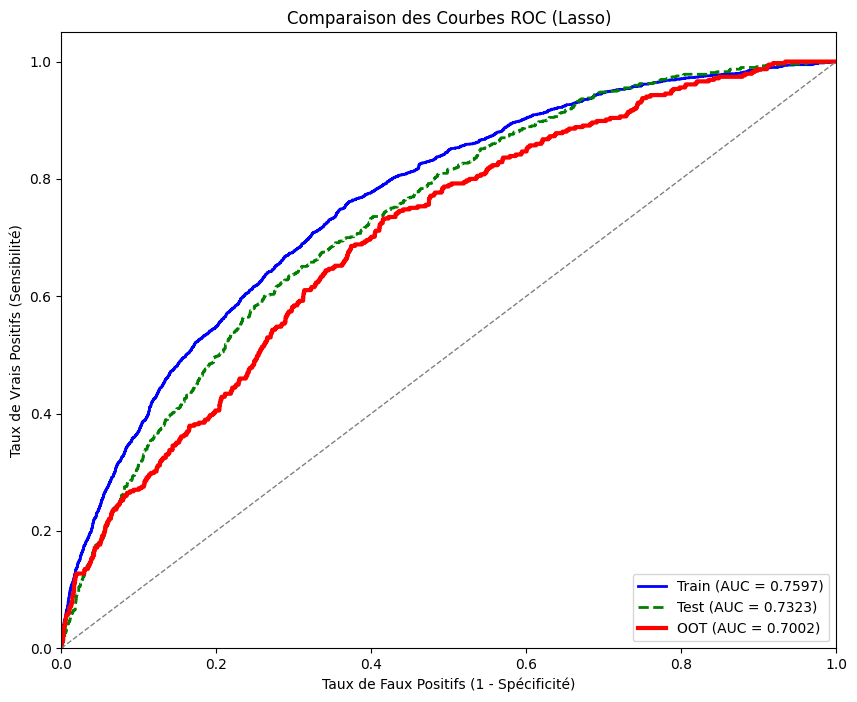

In [105]:
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
fpr_oot, tpr_oot, _ = roc_curve(y_oot, probs_oot)
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train (AUC = {auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, linestyle='--', label=f'Test (AUC = {auc_test:.4f})')
plt.plot(fpr_oot, tpr_oot, color='red', lw=3, label=f'OOT (AUC = {auc_oot:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Comparaison des Courbes ROC (Lasso)')
plt.legend(loc="lower right")
plt.grid(alpha=0)

In [106]:
coeffs = best_lasso.coef_[0]
feature_names = X_train_encoded.columns

scorecard = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coeffs,
    'Importance': np.abs(coeffs)
})

scorecard = scorecard[scorecard['Coefficient'] != 0].sort_values(by='Importance', ascending=False)
scorecard['Odds_Ratio'] = np.exp(scorecard['Coefficient'])

print("--- VARIABLES DU MODÈLE FINAL ---")
display(scorecard)

--- VARIABLES DU MODÈLE FINAL ---


,Variable,Coefficient,Importance,Odds_Ratio
0,GrossApproval,-0.749873,0.749873,0.472427
20,ratio_loan_guarantee,0.584726,0.584726,1.794498
32,SBADistrictOffice,-0.496649,0.496649,0.608567
34,Subprogram,-0.394429,0.394429,0.674065
28,Inflation_variation_Lag2_Annee,0.380789,0.380789,1.463438
37,CollateralInd,-0.280377,0.280377,0.755499
17,part_emprunt_vs_industry,-0.255942,0.255942,0.774187
33,IndustryName,-0.240282,0.240282,0.786406
12,taille_emprunt__vs_industry_med,0.200001,0.200001,1.221404
15,delta_emprunt_vs_industry_mean,-0.185848,0.185848,0.830400


In [107]:
def calculate_gini(auc_score):
    return 2 * auc_score - 1


def relative_gini(gini_train, gini_test):
    if gini_train == 0:
        return 0
    return (gini_train - gini_test) / gini_train

In [108]:
gini_train = calculate_gini(auc_train)
gini_test = calculate_gini(auc_test)
gini_oot = calculate_gini(auc_oot)    
drop1 = relative_gini(gini_train, gini_test)
drop2 = relative_gini(gini_train, gini_oot)

print("###################################################\n")
print(f"Gini train {gini_train}\n")
print("###################################################\n")
print(f"Gini test {gini_test}\n")
print("###################################################\n")
print(f"Gini oot {gini_oot}\n")
print("###################################################\n")
print(f"Perte de perf train test : {drop1:.2%}\n")
print("###################################################\n")
print(f"Perte de perf train oot : {drop2:.2%}\n")
print("###################################################\n")

###################################################

Gini train 0.5194846998876805

###################################################

Gini test 0.4646082748976639

###################################################

Gini oot 0.4004828351795262

###################################################

Perte de perf train test : 10.56%

###################################################

Perte de perf train oot : 22.91%

###################################################



## 8.2 Régression logistique Elastic net

In [109]:
elastic_model = LogisticRegression(
    penalty='elasticnet', 
    solver='saga', 
    max_iter=5000, 
    random_state=42, 
    class_weight='balanced'
)

param_grid = {
    'C': [0.001, 0.01, 0.05, 0.1, 0.5],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 1.0] 
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    elastic_model, 
    param_grid, 
    cv=tscv, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_encoded, y_train)

best_elastic = grid_search.best_estimator_
best_C = grid_search.best_params_['C']
best_l1_ratio = grid_search.best_params_['l1_ratio']

print(f"Meilleurs paramètres : C={best_C}, l1_ratio={best_l1_ratio}")


coeffs = best_elastic.coef_[0]
feature_names = X_train_encoded.columns

elastic_coefs = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coeffs,
    'Importance_Absolue': np.abs(coeffs)
})


survivors = elastic_coefs[elastic_coefs['Coefficient'] != 0].sort_values(by='Importance_Absolue', ascending=False)
vars_to_check = survivors['Variable'].tolist()
corr_matrix = X_train_encoded[vars_to_check].corr(method="spearman").abs()

vars_to_drop = set()
vars_final = []

for i in range(len(vars_to_check)):
    col_1 = vars_to_check[i]
    
    if col_1 in vars_to_drop:
        continue
    
    vars_final.append(col_1)
    
    for j in range(i + 1, len(vars_to_check)):
        col_2 = vars_to_check[j]
        
        if col_2 in vars_to_drop:
            continue
            
        if corr_matrix.loc[col_1, col_2] > 0.5:
            vars_to_drop.add(col_2)

X_train_final = X_train_encoded[vars_final]
X_test_final = X_test_encoded[vars_final]
X_oot_final = X_oot_encoded[vars_final]

final_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    C=best_C,
    l1_ratio=best_l1_ratio,
    max_iter=5000,
    random_state=42,
    class_weight='balanced'
)

final_model.fit(X_train_final, y_train)

probs_train = final_model.predict_proba(X_train_final)[:, 1]
probs_test = final_model.predict_proba(X_test_final)[:, 1]
probs_oot = final_model.predict_proba(X_oot_final)[:, 1]

auc_train = roc_auc_score(y_train, probs_train)
auc_test = roc_auc_score(y_test, probs_test)
auc_oot = roc_auc_score(y_oot, probs_oot)

print("-" * 30)
print(f"Variables initiales : {len(feature_names)}")
print(f"Variables après Elastic Net (Coeff != 0) : {len(survivors)}")
print(f"Variables finales (Net + Corr < 0.5) : {len(vars_final)}")
print("-" * 30)
print(f"AUC Train Final : {auc_train:.4f}")
print(f"AUC Test Final  : {auc_test:.4f}")
print(f"AUC OOT Final   : {auc_oot:.4f}")

/Users/marwan/Desktop/Cours/M2_MoSEF/machine_learning/Machine_Learning_projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marwan/Desktop/Cours/M2_MoSEF/machine_learning/Machine_Learning_projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marwan/Desktop/Cours/M2_MoSEF/machine_learning/Machine_Learning_projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marwan/Desktop/Cours/M2_MoSEF/machine_learning/Machine_Learning_projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Meilleurs paramètres : C=0.5, l1_ratio=0.1
------------------------------
Variables initiales : 38
Variables après Elastic Net (Coeff != 0) : 38
Variables finales (Net + Corr < 0.5) : 11
------------------------------
AUC Train Final : 0.7630
AUC Test Final  : 0.7348
AUC OOT Final   : 0.7360


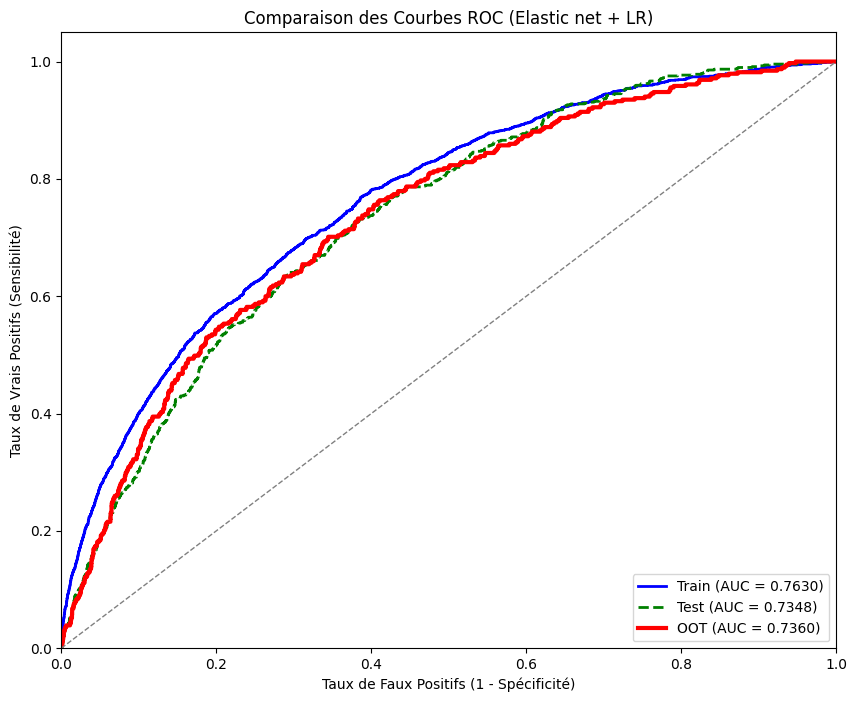

In [110]:
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
fpr_oot, tpr_oot, _ = roc_curve(y_oot, probs_oot)
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train (AUC = {auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, linestyle='--', label=f'Test (AUC = {auc_test:.4f})')
plt.plot(fpr_oot, tpr_oot, color='red', lw=3, label=f'OOT (AUC = {auc_oot:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Comparaison des Courbes ROC (Elastic net + LR)')
plt.legend(loc="lower right")
plt.grid(alpha=0)

In [111]:
gini_train = calculate_gini(auc_train)
gini_test = calculate_gini(auc_test)
gini_oot = calculate_gini(auc_oot)    
drop1 = relative_gini(gini_train, gini_test)
drop2 = relative_gini(gini_train, gini_oot)

print("###################################################\n")
print(f"Gini train {gini_train}\n")
print("###################################################\n")
print(f"Gini test {gini_test}\n")
print("###################################################\n")
print(f"Gini oot {gini_oot}\n")
print("###################################################\n")
print(f"Perte de perf train test : {drop1:.2%}\n")
print("###################################################\n")
print(f"Perte de perf train oot : {drop2:.2%}\n")
print("###################################################\n")

###################################################

Gini train 0.5260832984704762

###################################################

Gini test 0.4695711576740518

###################################################

Gini oot 0.47195915297937363

###################################################

Perte de perf train test : 10.74%

###################################################

Perte de perf train oot : 10.29%

###################################################



## 8.3 XGBOOST + Elastic net

In [114]:
elastic_model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, random_state=42, class_weight='balanced')

param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0] 
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    elastic_model, 
    param_grid, 
    cv=tscv, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_encoded, y_train)

best_elastic = grid_search.best_estimator_
coeffs = best_elastic.coef_[0]
feature_names = X_train_encoded.columns

elastic_coefs = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coeffs,
    'Importance_Absolue': np.abs(coeffs)
})

survivors = elastic_coefs[elastic_coefs['Coefficient'] != 0].sort_values(by='Importance_Absolue', ascending=False)
vars_to_check = survivors['Variable'].tolist()

print(f"2. Filtrage corrélation sur {len(vars_to_check)} variables...")
corr_matrix = X_train_encoded[vars_to_check].corr(method="spearman").abs()

vars_to_drop = set()
vars_final = []

for i in range(len(vars_to_check)):
    col_1 = vars_to_check[i]
    if col_1 in vars_to_drop: continue
    
    vars_final.append(col_1)
    
    for j in range(i + 1, len(vars_to_check)):
        col_2 = vars_to_check[j]
        if col_2 in vars_to_drop: continue
            
        if corr_matrix.loc[col_1, col_2] > 0.6: 
            vars_to_drop.add(col_2)

X_train_final = X_train[vars_final].copy()
X_test_final = X_test[vars_final].copy()
X_oot_final = X_oot[vars_final].copy()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
new_columns = [regex.sub("_", col) for col in vars_final]

X_train_final.columns = new_columns
X_test_final.columns = new_columns
X_oot_final.columns = new_columns

scale_pos_weight = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    early_stopping_rounds=30
)

xgb_model.fit(
    X_train_final, y_train,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

probs_train = xgb_model.predict_proba(X_train_final)[:, 1]
probs_test = xgb_model.predict_proba(X_test_final)[:, 1]
probs_oot = xgb_model.predict_proba(X_oot_final)[:, 1]

auc_train = roc_auc_score(y_train, probs_train)
auc_test = roc_auc_score(y_test, probs_test)
auc_oot = roc_auc_score(y_oot, probs_oot)

print("-" * 30)
print(f"Variables initiales : {len(feature_names)}")
print(f"Variables après Elastic Net : {len(survivors)}")
print(f"Variables finales (Net + Corr < 0.6) : {len(vars_final)}")
print("-" * 30)
print(f"AUC Train (XGBoost) : {auc_train:.4f}")
print(f"AUC Test  (XGBoost) : {auc_test:.4f}")
print(f"AUC OOT   (XGBoost) : {auc_oot:.4f}")

/Users/marwan/Desktop/Cours/M2_MoSEF/machine_learning/Machine_Learning_projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marwan/Desktop/Cours/M2_MoSEF/machine_learning/Machine_Learning_projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marwan/Desktop/Cours/M2_MoSEF/machine_learning/Machine_Learning_projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


2. Filtrage corrélation sur 38 variables...
------------------------------
Variables initiales : 38
Variables après Elastic Net : 38
Variables finales (Net + Corr < 0.6) : 15
------------------------------
AUC Train (XGBoost) : 0.8465
AUC Test  (XGBoost) : 0.8049
AUC OOT   (XGBoost) : 0.7760


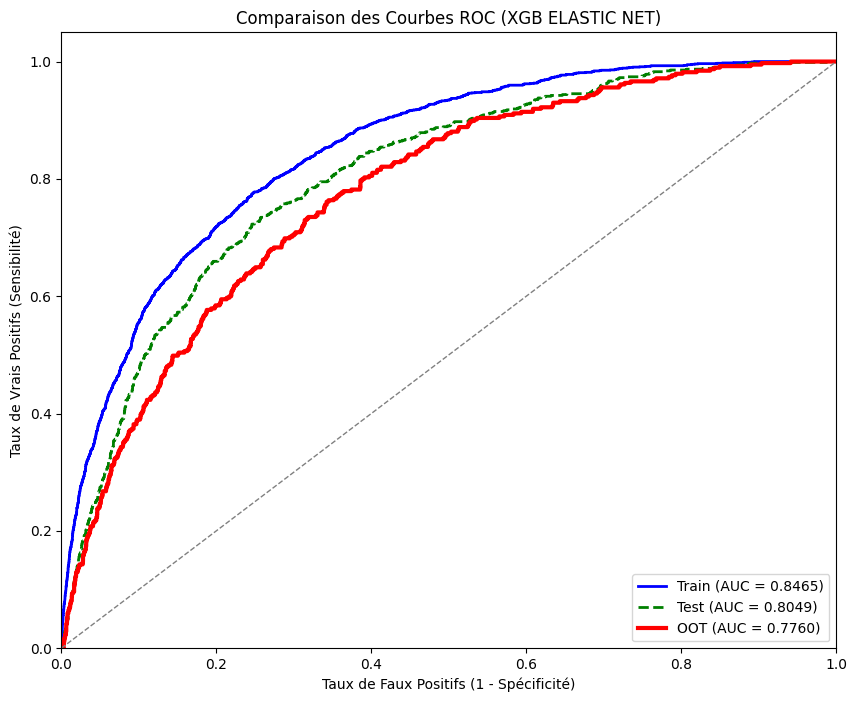

In [115]:
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
fpr_oot, tpr_oot, _ = roc_curve(y_oot, probs_oot)
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train (AUC = {auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, linestyle='--', label=f'Test (AUC = {auc_test:.4f})')
plt.plot(fpr_oot, tpr_oot, color='red', lw=3, label=f'OOT (AUC = {auc_oot:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Comparaison des Courbes ROC (XGB ELASTIC NET)')
plt.legend(loc="lower right")
plt.grid(alpha=0)

In [116]:
0.7760*2-1

0.552

In [117]:
gini_train = calculate_gini(auc_train)
gini_test = calculate_gini(auc_test)
gini_oot = calculate_gini(auc_oot)    
drop1 = relative_gini(gini_train, gini_test)
drop2 = relative_gini(gini_train, gini_oot)

print("###################################################\n")
print(f"Gini train {gini_train}\n")
print("###################################################\n")
print(f"Gini test {gini_test}\n")
print("###################################################\n")
print(f"Gini oot {gini_oot}\n")
print("###################################################\n")
print(f"Perte de perf train test : {drop1:.2%}\n")
print("###################################################\n")
print(f"Perte de perf train oot : {drop2:.2%}\n")
print("###################################################\n")

###################################################

Gini train 0.69292348620522

###################################################

Gini test 0.6097596579911693

###################################################

Gini oot 0.5520918878915202

###################################################

Perte de perf train test : 12.00%

###################################################

Perte de perf train oot : 20.32%

###################################################

